# Purpose
- goal is to use DLC-estimated key points and define behavioral epochs
- data is from Alex F from Knowles lab, and we want to quanitfy:

1. time in light box (time visible)
    - nose only
    - nose and ears
    - nose and ears and butt
2. distance to edge IN REAL COORDINATES
    - adjust marked coordinates to real coordinates (50cm2 box)
    - get animal position relative to corners
3. #, timing, location of rearing events
4. #, timing, location of jumps


# TODO subset by time

This notebook is meant to accompany alex_openfield.py First, we generate a single file with additional visualizations and discussion of process that went into the functions used in alex_openfield.py Then, we import a set of annotations and train a classifier on the data. 

# imports

In [1]:
import numpy as np
import pandas as pd
import glob, os, csv
import matplotlib.pyplot as plt

In [2]:
import cv2

In [3]:
from sklearn.model_selection import train_test_split
from scipy.io import arff
import math

In [4]:
import itertools

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
import warnings
warnings.filterwarnings(action='once')

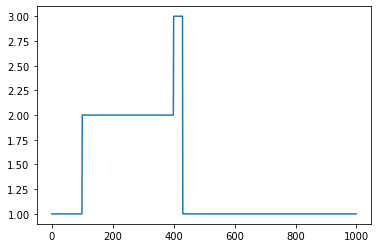

In [19]:
tst=pd.Series(tst)
plt.plot(tst)

bodyparts      box_tl                              box_tr              \
         coords           x           y likelihood            x           y   
0             0  123.282234  604.767883   0.849111  1037.865601  601.710999   
1             1  124.128983  605.464355   0.878008  1039.489136  602.170654   
2             2  124.536484  606.336670   0.824448  1039.823486  602.374329   
3             3  123.077713  605.665894   0.834720  1039.113403  602.557312   
4             4  122.662643  605.798340   0.846286  1038.319336  602.590454   
...         ...         ...         ...        ...          ...         ...   
26701     26701  120.533356  596.007385   0.570577  1049.727539  593.745911   
26702     26702  122.778015  597.712158   0.535664  1050.912354  593.551880   
26703     26703  119.128784  595.424500   0.296917  1050.853394  593.584290   
26704     26704  120.131783  595.289917   0.268319  1050.036377  593.518677   
26705     26705  119.186470  594.915222   0.375068  1049.778809  593.523438   

                      box_bl                          ... paw_left_front  \
      likelihood           x            y likelihood  ...     likelihood   
0       0.814701  134.437241  1495.901978   0.958396  ...       0.027658   
1       0.848482  136.134171  1496.551880   0.965831  ...       0.028131   
2       0.843395  135.288895  1497.877930   0.967991  ...       0.040655   
3       0.827480  134.264847  1498.222778   0.976191  ...       0.048446   
4       0.829821  133.671661  1497.420166   0.972480  ...       0.047412   
...          ...         ...          ...        ...  ...            ...   
26701   0.982392  134.046677  1499.777954   0.947789  ...       0.046575   
26702   0.984547  135.918488  1499.254517   0.967313  ...       0.041593   
26703   0.980523  132.918365  1500.495972   0.974463  ...       0.042716   
26704   0.979844  132.855270  1498.420532   0.975460  ...       0.044276   
26705   0.981045  132.254211  1498.876343   0.972106  ...       0.045228   

      paw_right_front                         paw_left_back               \
                    x            y likelihood             x            y   
0          633.914429   595.811829   0.026815    640.650879   596.409912   
1          634.786316   595.568481   0.028968    641.807495   596.819397   
2          321.308746  1495.105591   0.039446    640.905273   597.664368   
3          320.293671  1493.841553   0.053130    321.882141  1496.409546   
4          320.324097  1493.623901   0.052558    321.976562  1496.035767   
...               ...          ...        ...           ...          ...   
26701      641.930481   588.247559   0.069196    644.460022   585.352783   
26702      640.674866   586.697754   0.077179    645.909912   585.431274   
26703      641.174500   588.151978   0.066901    644.376831   585.197571   
26704      641.715820   587.968628   0.065114    644.729431   585.043152   
26705      641.228638   588.089355   0.066380    644.358521   584.976257   

                 paw_right_back                          
      likelihood              x            y likelihood  
0       0.050391     326.514557  1497.064697   0.039084  
1       0.059205     325.212036  1498.242676   0.043317  
2       0.065313     323.642639  1499.183594   0.079000  
3       0.056105     321.398346  1499.296265   0.084810  
4       0.055851     321.297852  1499.304688   0.088096  
...          ...            ...          ...        ...  
26701   0.068443     642.566162   590.083374   0.067218  
26702   0.062326     644.471924   589.771057   0.063582  
26703   0.070483     642.211853   590.202087   0.063526  
26704   0.071115     642.656738   590.103333   0.058092  
26705   0.072774     641.789001   590.359741   0.064454  

[26706 rows x 46 columns]

# functions

In [48]:
def reformat_df(df,likelihood_val,max_px_value,frame_limit_val,seconds,fps):
    new_df=pd.DataFrame()
    cols = np.unique([col[0] for col in df.columns])
    for col in cols:
        if "bodyparts" not in col:
            part = df[col]
            for idx in np.arange(0,len(part.x)):
                if idx%100==0:
                    print('on {} of {}'.format(idx,len(part.x)))
                if part.likelihood[idx] < likelihood_val:
                    part.x[idx] = np.nan
                    part.y[idx] = np.nan
            if "box" not in col and "opening" not in col and "bodyparts" not in col:
                for idx in np.arange(0,len(part.x)):
                    second_idx = np.max([0,idx-1])
                    if abs(part.y[idx]-part.y[second_idx]) > max_px_value:
                        part.y[idx] = np.nan
                    elif abs(part.x[idx]-part.x[second_idx]) > max_px_value:
                        part.x[idx] = np.nan
                part.x = part.x.interpolate(limit=frame_limit_val)
                part.y = part.y.interpolate(limit=frame_limit_val)
                new_part = pd.concat({col:part},axis=1)
                if col == cols[1]:
                    new_df=new_part
                else:
                    new_df = pd.concat([new_df,new_part],axis=1)
            else:
                part.x = part.x.interpolate()
                part.x=part.x.rolling(seconds*fps,min_periods=1).median()
                part.y = part.y.interpolate()
                part.y=part.y.rolling(seconds*fps,min_periods=1).median()
                new_location = pd.concat({col:part},axis=1)
                new_df=pd.concat([new_df,new_location],axis=1)
            
    return new_df

In [49]:
def alt_reformat_df(df,likelihood_val,max_px_value,frame_limit_val,seconds,fps):
    new_df=pd.DataFrame()
    cols = np.unique([col[0] for col in df.columns])
    for col in cols:
        print(col)
        if "bodyparts" not in col:
            part = df[col]
            for idx in np.arange(0,len(part.x)):
                if idx%100==0:
                    print('on {} of {}'.format(idx,len(part.x)))
                if part.likelihood[idx] < likelihood_val:
                    part.x[idx] = np.nan
                    part.y[idx] = np.nan
                second_idx = np.max([0,idx-1])
                if abs(part.y[idx]-part.y[second_idx]) > max_px_value:
                    part[idx] = np.nan
                elif abs(part.x[idx]-part.x[second_idx]) > max_px_value:
                    part.x[idx] = np.nan

            if "box" not in col and "opening" not in col and "bodyparts" not in col:
                part.x = part.x.interpolate(limit=frame_limit_val)
                part.y = part.y.interpolate(limit=frame_limit_val)
                new_part = pd.concat({col:part},axis=1)
                if col == cols[1]:
                    new_df=new_part
                else:
                    new_df = pd.concat([new_df,new_part],axis=1)
            else:
                print('interp x')
                part.x = part.x.interpolate()
                print('roll x')
                part.x=part.x.rolling(seconds*fps,min_periods=1).median()
                print('interp y')
                part.y = part.y.interpolate()
                print('roll y')
                part.y=part.y.rolling(seconds*fps,min_periods=1).median()
                new_location = pd.concat({col:part},axis=1)
                new_df=pd.concat([new_df,new_location],axis=1)
            
    return new_df

In [8]:
def align_df(df):
    new_df=pd.DataFrame()
    # for each index, get the box coords, find transformation matrix, then apply it to all other points
    s1=[0,500]
    s2=[500,500]
    s3=[0,0]
    s4=[500,0]
    for idx in np.arange(0,len(df)):
        if idx%1000==0:
            print('at {} of {} rows'.format(idx,len(df)))
        # get box points
        p1=[df.box_bl.x[idx],df.box_bl.y[idx]] #0,500
        p2=[df.box_br.x[idx],df.box_br.y[idx]] #500,500
        p3=[df.box_tl.x[idx],df.box_tl.y[idx]] #0,0
        p4=[df.box_tr.x[idx],df.box_tr.y[idx]] #500,0
        # get transform matrix
        M = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))
        # apply transform matrix to other points
        sub_df=df[df.index==idx].copy()
        for i in np.arange(0,len(sub_df.columns),3):
            p1_0=sub_df.iloc[0,i]
            p1_1=sub_df.iloc[0,i+1]
            if np.isnan(p1_0):
                p1_0_new=np.nan
                p1_1_new=np.nan
            else:
                # set points
                pts = np.array([[[p1_0,p1_1]]],dtype='float32')
                # use transform matrix to un-warp the points
                [p1_0_new,p1_1_new]=cv2.perspectiveTransform(pts,M)[0][0]
            sub_df.iloc[0,i]=p1_0_new
            sub_df.iloc[0,i+1]=p1_1_new
        new_df=pd.concat([new_df,sub_df],axis=0)
    return new_df

# load an example file, preprocess data (exclude outliers, smooth)

In [9]:
FPS=29.93

In [50]:
filename = '../../../videos/bad_alex_data/VID_20220502_133606DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000.csv'

In [51]:
df = pd.read_csv(filename,header=[1,2])
df

bodyparts      box_tl                              box_tr              \
         coords           x           y likelihood            x           y   
0             0  123.282234  604.767883   0.849111  1037.865601  601.710999   
1             1  124.128983  605.464355   0.878008  1039.489136  602.170654   
2             2  124.536484  606.336670   0.824448  1039.823486  602.374329   
3             3  123.077713  605.665894   0.834720  1039.113403  602.557312   
4             4  122.662643  605.798340   0.846286  1038.319336  602.590454   
...         ...         ...         ...        ...          ...         ...   
26701     26701  120.533356  596.007385   0.570577  1049.727539  593.745911   
26702     26702  122.778015  597.712158   0.535664  1050.912354  593.551880   
26703     26703  119.128784  595.424500   0.296917  1050.853394  593.584290   
26704     26704  120.131783  595.289917   0.268319  1050.036377  593.518677   
26705     26705  119.186470  594.915222   0.375068  1049.778809  593.523438   

                      box_bl                          ... paw_left_front  \
      likelihood           x            y likelihood  ...     likelihood   
0       0.814701  134.437241  1495.901978   0.958396  ...       0.027658   
1       0.848482  136.134171  1496.551880   0.965831  ...       0.028131   
2       0.843395  135.288895  1497.877930   0.967991  ...       0.040655   
3       0.827480  134.264847  1498.222778   0.976191  ...       0.048446   
4       0.829821  133.671661  1497.420166   0.972480  ...       0.047412   
...          ...         ...          ...        ...  ...            ...   
26701   0.982392  134.046677  1499.777954   0.947789  ...       0.046575   
26702   0.984547  135.918488  1499.254517   0.967313  ...       0.041593   
26703   0.980523  132.918365  1500.495972   0.974463  ...       0.042716   
26704   0.979844  132.855270  1498.420532   0.975460  ...       0.044276   
26705   0.981045  132.254211  1498.876343   0.972106  ...       0.045228   

      paw_right_front                         paw_left_back               \
                    x            y likelihood             x            y   
0          633.914429   595.811829   0.026815    640.650879   596.409912   
1          634.786316   595.568481   0.028968    641.807495   596.819397   
2          321.308746  1495.105591   0.039446    640.905273   597.664368   
3          320.293671  1493.841553   0.053130    321.882141  1496.409546   
4          320.324097  1493.623901   0.052558    321.976562  1496.035767   
...               ...          ...        ...           ...          ...   
26701      641.930481   588.247559   0.069196    644.460022   585.352783   
26702      640.674866   586.697754   0.077179    645.909912   585.431274   
26703      641.174500   588.151978   0.066901    644.376831   585.197571   
26704      641.715820   587.968628   0.065114    644.729431   585.043152   
26705      641.228638   588.089355   0.066380    644.358521   584.976257   

                 paw_right_back                          
      likelihood              x            y likelihood  
0       0.050391     326.514557  1497.064697   0.039084  
1       0.059205     325.212036  1498.242676   0.043317  
2       0.065313     323.642639  1499.183594   0.079000  
3       0.056105     321.398346  1499.296265   0.084810  
4       0.055851     321.297852  1499.304688   0.088096  
...          ...            ...          ...        ...  
26701   0.068443     642.566162   590.083374   0.067218  
26702   0.062326     644.471924   589.771057   0.063582  
26703   0.070483     642.211853   590.202087   0.063526  
26704   0.071115     642.656738   590.103333   0.058092  
26705   0.072774     641.789001   590.359741   0.064454  

[26706 rows x 46 columns]

In [52]:
num=filename.split('/')[-1][0:19]
print(num)

VID_20220502_133606


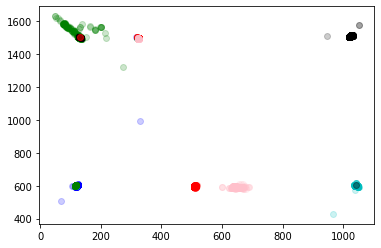

In [53]:
a=0
b=-1
plt.scatter(df.box_tl["x"][a:b],df.box_tl["y"][a:b],c='b',alpha=0.2)
plt.scatter(df.box_tr["x"][a:b],df.box_tr["y"][a:b],c='c',alpha=0.2)
plt.scatter(df.box_bl["x"][a:b],df.box_bl["y"][a:b],c='g',alpha=0.2)
plt.scatter(df.box_br["x"][a:b],df.box_br["y"][a:b],c='k',alpha=0.2)
plt.scatter(df.opening_bottom["x"][a:b],df.opening_bottom["y"][a:b],c='r',alpha=0.2)
plt.scatter(df.opening_top["x"][a:b],df.opening_top["y"][a:b],c='pink',alpha=0.2)
plt.show()

## which rolling window is "good" at discarding random jumps in assignment but still capturing the slides?

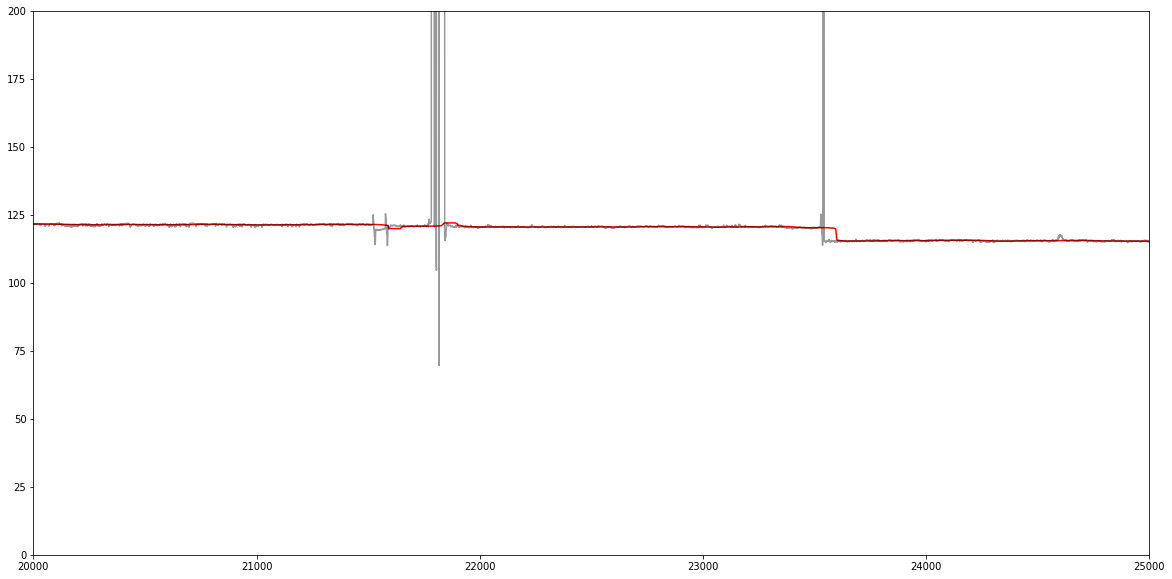

In [54]:
s = df.box_tl["x"]
plt.figure(figsize=(20,10))
plt.plot(s.rolling(4*30).median(),c='r')
plt.plot(s,c='k',alpha=0.4)
plt.ylim(0,200)
plt.xlim(20000,25000)
plt.show()

### what adjustments do we need for body parts?

In [ ]:
new_df=alt_reformat_df(df,0.9,1000,15,4,30)

bodyparts
box_bl
on 0 of 26706
on 100 of 26706
on 200 of 26706
on 300 of 26706
on 400 of 26706
on 500 of 26706
on 600 of 26706
on 700 of 26706
on 800 of 26706
on 900 of 26706
on 1000 of 26706
on 1100 of 26706
on 1200 of 26706
on 1300 of 26706
on 1400 of 26706
on 1500 of 26706
on 1600 of 26706
on 1700 of 26706
on 1800 of 26706
on 1900 of 26706
on 2000 of 26706
on 2100 of 26706
on 2200 of 26706
on 2300 of 26706
on 2400 of 26706
on 2500 of 26706
on 2600 of 26706
on 2700 of 26706
on 2800 of 26706
on 2900 of 26706
on 3000 of 26706
on 3100 of 26706
on 3200 of 26706
on 3300 of 26706
on 3400 of 26706
on 3500 of 26706
on 3600 of 26706
on 3700 of 26706
on 3800 of 26706
on 3900 of 26706
on 4000 of 26706
on 4100 of 26706
on 4200 of 26706
on 4300 of 26706
on 4400 of 26706
on 4500 of 26706
on 4600 of 26706
on 4700 of 26706
on 4800 of 26706
on 4900 of 26706
on 5000 of 26706
on 5100 of 26706
on 5200 of 26706
on 5300 of 26706
on 5400 of 26706
on 5500 of 26706
on 5600 of 26706
on 5700 of 26706
on 5800 o

/tmp/ipykernel_11388/184196750.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x[idx] = np.nan


on 21600 of 26706
on 21700 of 26706
on 21800 of 26706
on 21900 of 26706
on 22000 of 26706
on 22100 of 26706
on 22200 of 26706
on 22300 of 26706
on 22400 of 26706
on 22500 of 26706
on 22600 of 26706
on 22700 of 26706
on 22800 of 26706
on 22900 of 26706
on 23000 of 26706
on 23100 of 26706
on 23200 of 26706
on 23300 of 26706
on 23400 of 26706
on 23500 of 26706
on 23600 of 26706
on 23700 of 26706
on 23800 of 26706
on 23900 of 26706
on 24000 of 26706
on 24100 of 26706
on 24200 of 26706
on 24300 of 26706
on 24400 of 26706
on 24500 of 26706
on 24600 of 26706
on 24700 of 26706
on 24800 of 26706
on 24900 of 26706
on 25000 of 26706
on 25100 of 26706
on 25200 of 26706
on 25300 of 26706
on 25400 of 26706
on 25500 of 26706
on 25600 of 26706
on 25700 of 26706
on 25800 of 26706
on 25900 of 26706
on 26000 of 26706
on 26100 of 26706
on 26200 of 26706
on 26300 of 26706
on 26400 of 26706
on 26500 of 26706
on 26600 of 26706
on 26700 of 26706
interp x
roll x
interp y
roll y
box_br
on 0 of 26706
on 100 of 2

/tmp/ipykernel_11388/184196750.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate()
/tmp/ipykernel_11388/184196750.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x[idx] = np.nan


on 21200 of 26706
on 21300 of 26706
on 21400 of 26706
on 21500 of 26706
on 21600 of 26706
on 21700 of 26706
on 21800 of 26706
on 21900 of 26706
on 22000 of 26706
on 22100 of 26706
on 22200 of 26706
on 22300 of 26706
on 22400 of 26706
on 22500 of 26706
on 22600 of 26706
on 22700 of 26706
on 22800 of 26706
on 22900 of 26706
on 23000 of 26706
on 23100 of 26706
on 23200 of 26706
on 23300 of 26706
on 23400 of 26706
on 23500 of 26706
on 23600 of 26706
on 23700 of 26706
on 23800 of 26706
on 23900 of 26706
on 24000 of 26706
on 24100 of 26706
on 24200 of 26706
on 24300 of 26706
on 24400 of 26706
on 24500 of 26706
on 24600 of 26706
on 24700 of 26706
on 24800 of 26706
on 24900 of 26706
on 25000 of 26706
on 25100 of 26706
on 25200 of 26706
on 25300 of 26706
on 25400 of 26706
on 25500 of 26706
on 25600 of 26706
on 25700 of 26706
on 25800 of 26706
on 25900 of 26706
on 26000 of 26706
on 26100 of 26706
on 26200 of 26706
on 26300 of 26706
on 26400 of 26706
on 26500 of 26706
on 26600 of 26706
on 26700 o

/tmp/ipykernel_11388/184196750.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate()
/tmp/ipykernel_11388/184196750.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x[idx] = np.nan


on 100 of 26706
on 200 of 26706
on 300 of 26706
on 400 of 26706
on 500 of 26706
on 600 of 26706
on 700 of 26706
on 800 of 26706
on 900 of 26706
on 1000 of 26706
on 1100 of 26706
on 1200 of 26706
on 1300 of 26706
on 1400 of 26706
on 1500 of 26706
on 1600 of 26706
on 1700 of 26706
on 1800 of 26706
on 1900 of 26706
on 2000 of 26706
on 2100 of 26706
on 2200 of 26706
on 2300 of 26706
on 2400 of 26706
on 2500 of 26706
on 2600 of 26706
on 2700 of 26706
on 2800 of 26706
on 2900 of 26706
on 3000 of 26706
on 3100 of 26706
on 3200 of 26706
on 3300 of 26706
on 3400 of 26706
on 3500 of 26706
on 3600 of 26706
on 3700 of 26706
on 3800 of 26706
on 3900 of 26706
on 4000 of 26706
on 4100 of 26706
on 4200 of 26706
on 4300 of 26706
on 4400 of 26706
on 4500 of 26706
on 4600 of 26706
on 4700 of 26706
on 4800 of 26706
on 4900 of 26706
on 5000 of 26706
on 5100 of 26706
on 5200 of 26706
on 5300 of 26706
on 5400 of 26706
on 5500 of 26706
on 5600 of 26706
on 5700 of 26706
on 5800 of 26706
on 5900 of 26706
on 600

/tmp/ipykernel_11388/184196750.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate()
/tmp/ipykernel_11388/184196750.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x[idx] = np.nan


on 100 of 26706
on 200 of 26706
on 300 of 26706
on 400 of 26706
on 500 of 26706
on 600 of 26706
on 700 of 26706
on 800 of 26706
on 900 of 26706
on 1000 of 26706
on 1100 of 26706
on 1200 of 26706
on 1300 of 26706
on 1400 of 26706
on 1500 of 26706
on 1600 of 26706
on 1700 of 26706
on 1800 of 26706
on 1900 of 26706
on 2000 of 26706
on 2100 of 26706
on 2200 of 26706
on 2300 of 26706
on 2400 of 26706
on 2500 of 26706
on 2600 of 26706
on 2700 of 26706
on 2800 of 26706
on 2900 of 26706
on 3000 of 26706
on 3100 of 26706
on 3200 of 26706
on 3300 of 26706
on 3400 of 26706
on 3500 of 26706
on 3600 of 26706
on 3700 of 26706
on 3800 of 26706
on 3900 of 26706
on 4000 of 26706
on 4100 of 26706
on 4200 of 26706
on 4300 of 26706
on 4400 of 26706
on 4500 of 26706
on 4600 of 26706
on 4700 of 26706
on 4800 of 26706
on 4900 of 26706
on 5000 of 26706
on 5100 of 26706
on 5200 of 26706
on 5300 of 26706
on 5400 of 26706
on 5500 of 26706
on 5600 of 26706
on 5700 of 26706
on 5800 of 26706
on 5900 of 26706
on 600

/tmp/ipykernel_11388/184196750.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate()
/tmp/ipykernel_11388/184196750.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x[idx] = np.nan


on 100 of 26706
on 200 of 26706
on 300 of 26706
on 400 of 26706
on 500 of 26706
on 600 of 26706
on 700 of 26706
on 800 of 26706
on 900 of 26706
on 1000 of 26706
on 1100 of 26706
on 1200 of 26706
on 1300 of 26706
on 1400 of 26706
on 1500 of 26706
on 1600 of 26706
on 1700 of 26706
on 1800 of 26706
on 1900 of 26706
on 2000 of 26706
on 2100 of 26706
on 2200 of 26706
on 2300 of 26706
on 2400 of 26706
on 2500 of 26706
on 2600 of 26706
on 2700 of 26706
on 2800 of 26706
on 2900 of 26706
on 3000 of 26706
on 3100 of 26706
on 3200 of 26706
on 3300 of 26706
on 3400 of 26706
on 3500 of 26706
on 3600 of 26706
on 3700 of 26706
on 3800 of 26706
on 3900 of 26706
on 4000 of 26706
on 4100 of 26706
on 4200 of 26706
on 4300 of 26706
on 4400 of 26706
on 4500 of 26706
on 4600 of 26706
on 4700 of 26706
on 4800 of 26706
on 4900 of 26706
on 5000 of 26706
on 5100 of 26706
on 5200 of 26706
on 5300 of 26706
on 5400 of 26706
on 5500 of 26706
on 5600 of 26706
on 5700 of 26706
on 5800 of 26706
on 5900 of 26706
on 600

In [ ]:
#new_df=reformat_df(df,0.9,1000,15,3,30)

In [ ]:
plt.scatter(new_df.box_bl['x'],new_df.box_bl['y'],c='r') #0,500mm
plt.scatter(new_df.box_br['x'],new_df.box_br['y'],c='pink') #500,500mm
plt.scatter(new_df.box_tl['x'],new_df.box_tl['y'],c='b') #0,0mm
plt.scatter(new_df.box_tr['x'],new_df.box_tr['y'],c='cyan') #500,0mm
plt.title('smoothed corner points before registering to mm space')
plt.show()

In [174]:
total_frames=[]
num_entrances=[]
first_frame_in_center=[]
frames_with_nose=[]
frames_with_head=[]
frames_with_body=[]
frames_within_50mm=[]
fraction_frames_within_50mm=[]
fraction_LIGHT_frames_within_50mm=[]
fraction_LIGHT_frames_in_center=[]

In [175]:
#filename[:-4]+"_adj.csv"
new_df.to_csv(filename[:-4]+"_adj.csv")

In [176]:
new_df = pd.read_csv(filename[:-4]+"_adj.csv",header=[0,1],index_col=0)

In [177]:
new_df

box_bl                               box_br               \
                x            y likelihood            x            y   
0      289.876923  1018.111084   0.931658  1210.977051  1003.794922   
1      289.874008  1018.102783   0.935111  1210.979004  1003.792297   
2      289.876923  1018.111084   0.940634  1210.977051  1003.794922   
3      289.897522  1018.300842   0.948916  1210.882507  1004.172699   
4      289.883453  1018.490601   0.938299  1210.787964  1004.550476   
...           ...          ...        ...          ...          ...   
22343  307.595520   241.685501   0.158650  1124.301025  1057.871582   
22344  307.595520   241.685501   0.130513  1124.301025  1057.893148   
22345  307.595520   241.685501   0.102661  1124.301025  1057.893148   
22346  307.595520   241.685501   0.126629  1124.301025  1057.893148   
22347  307.595520   241.685501   0.126369  1124.301025  1057.893148   

                      box_tl                              box_tr  ...  \
      likelihood           x           y likelihood            x  ...   
0       0.941759  301.730804  108.617668   0.964572  1196.942749  ...   
1       0.941601  301.737671  108.566448   0.965643  1196.971558  ...   
2       0.933616  301.744537  108.617668   0.966945  1196.942749  ...   
3       0.945460  301.949020  108.693073   0.964701  1196.895752  ...   
4       0.959506  301.940460  108.768478   0.973381  1196.848755  ...   
...          ...         ...         ...        ...          ...  ...   
22343   0.990381  179.979408  125.450927   0.979074  1109.053589  ...   
22344   0.993274  179.979408  125.450927   0.967539  1109.053589  ...   
22345   0.983770  179.979408  125.450927   0.970679  1109.053589  ...   
22346   0.984074  179.979408  125.450927   0.973000  1109.053589  ...   
22347   0.990486  179.979408  125.450927   0.972165  1109.053589  ...   

      paw_right_back paw_right_front                tail_base                 \
          likelihood               x   y likelihood         x   y likelihood   
0           0.035138             NaN NaN   0.022386       NaN NaN   0.113262   
1           0.035057             NaN NaN   0.022345       NaN NaN   0.112553   
2           0.039068             NaN NaN   0.021519       NaN NaN   0.115557   
3           0.036387             NaN NaN   0.019557       NaN NaN   0.113786   
4           0.039933             NaN NaN   0.022847       NaN NaN   0.116465   
...              ...             ...  ..        ...       ...  ..        ...   
22343       0.053805             NaN NaN   0.045290       NaN NaN   0.082700   
22344       0.064209             NaN NaN   0.040356       NaN NaN   0.075062   
22345       0.073486             NaN NaN   0.038986       NaN NaN   0.072951   
22346       0.066577             NaN NaN   0.037409       NaN NaN   0.087203   
22347       0.059656             NaN NaN   0.036217       NaN NaN   0.069265   

      tail_tip                 
             x   y likelihood  
0          NaN NaN   0.140742  
1          NaN NaN   0.142184  
2          NaN NaN   0.150540  
3          NaN NaN   0.145448  
4          NaN NaN   0.173538  
...        ...  ..        ...  
22343      NaN NaN   0.149232  
22344      NaN NaN   0.159466  
22345      NaN NaN   0.159696  
22346      NaN NaN   0.121681  
22347      NaN NaN   0.102457  

[22348 rows x 45 columns]

In [178]:
part = new_df.box_tl

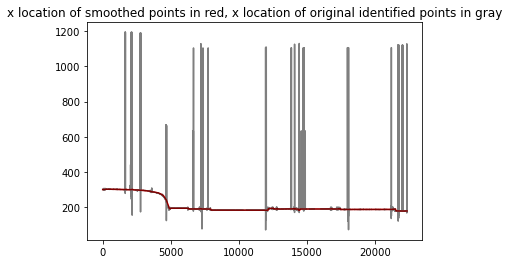

In [179]:
plt.plot(part.x.interpolate(limit=15),c='r',alpha=1)
plt.plot(s,c='k',alpha=0.5)
plt.title('x location of smoothed points in red, x location of original identified points in gray')
plt.show()

## affine transform of points to put into mm space (box is 500mm x 500mm)

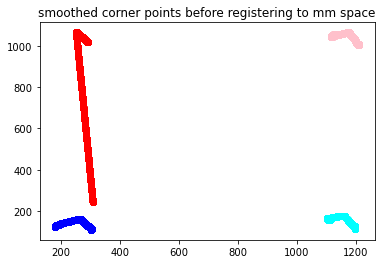

In [180]:
plt.scatter(new_df.box_bl['x'],new_df.box_bl['y'],c='r') #0,500mm
plt.scatter(new_df.box_br['x'],new_df.box_br['y'],c='pink') #500,500mm
plt.scatter(new_df.box_tl['x'],new_df.box_tl['y'],c='b') #0,0mm
plt.scatter(new_df.box_tr['x'],new_df.box_tr['y'],c='cyan') #500,0mm
plt.title('smoothed corner points before registering to mm space')
plt.show()

In [181]:
s1=[0,500]
s2=[500,500]
s3=[0,0]
s4=[500,0]
idx=1000
p1=[new_df.box_bl.x[idx],new_df.box_bl.y[idx]] #0,500
p2=[new_df.box_br.x[idx],new_df.box_br.y[idx]] #500,500
p3=[new_df.box_tl.x[idx],new_df.box_tl.y[idx]] #0,0
p4=[new_df.box_tr.x[idx],new_df.box_tr.y[idx]] #500,0
print(p1,p2,p3,p4)
print(s1,s2,s3,s4)

[289.65525817871094, 1020.2555847167968] [1207.823974609375, 1006.9124450683594] [302.60777282714844, 113.40282821655272] [1195.9943237304688, 121.28760147094728]
[0, 500] [500, 500] [0, 0] [500, 0]


In [182]:
# get a transform matrix
A2 = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))

# set points
pts = np.array([[p1]],dtype='float32')

# use transform matrix to un-warp the points
cv2.perspectiveTransform(pts,A2)

array([[[  0., 500.]]], dtype=float32)

In [183]:
aligned_df=align_df(new_df)
aligned_df

at 0 of 22348 rows
at 1000 of 22348 rows
at 2000 of 22348 rows
at 3000 of 22348 rows
at 4000 of 22348 rows
at 5000 of 22348 rows
at 6000 of 22348 rows
at 7000 of 22348 rows
at 8000 of 22348 rows
at 9000 of 22348 rows
at 10000 of 22348 rows
at 11000 of 22348 rows
at 12000 of 22348 rows
at 13000 of 22348 rows
at 14000 of 22348 rows
at 15000 of 22348 rows
at 16000 of 22348 rows
at 17000 of 22348 rows
at 18000 of 22348 rows
at 19000 of 22348 rows
at 20000 of 22348 rows
at 21000 of 22348 rows
at 22000 of 22348 rows


box_bl                             box_br                         \
                  x           y likelihood           x           y likelihood   
0      2.771090e-14  500.000000   0.931658  500.000000  500.000000   0.941759   
1      0.000000e+00  500.000000   0.935111  500.000000  500.000000   0.941601   
2     -2.771075e-14  500.000000   0.940634  500.000000  500.000000   0.933616   
3      0.000000e+00  500.000000   0.948916  500.000000  500.000000   0.945460   
4      0.000000e+00  500.000000   0.938299  500.000000  500.000000   0.959506   
...             ...         ...        ...         ...         ...        ...   
22343 -1.608186e-12  499.999359   0.158650  500.000458  500.000458   0.990381   
22344  0.000000e+00  499.999359   0.130513  500.000580  500.000580   0.993274   
22345  0.000000e+00  499.999359   0.102661  500.000580  500.000580   0.983770   
22346  0.000000e+00  499.999359   0.126629  500.000580  500.000580   0.984074   
22347  0.000000e+00  499.999359   0.126369  500.000580  500.000580   0.990486   

             box_tl                               box_tr  ... paw_right_back  \
                  x             y likelihood           x  ...     likelihood   
0      2.852164e-14  0.000000e+00   0.964572  500.000000  ...       0.035138   
1     -5.704484e-14  2.139181e-14   0.965643  500.000000  ...       0.035057   
2      0.000000e+00  2.852193e-14   0.966945  500.000000  ...       0.039068   
3      0.000000e+00  2.139023e-14   0.964701  500.000000  ...       0.036387   
4      0.000000e+00 -2.138940e-14   0.973381  500.000000  ...       0.039933   
...             ...           ...        ...         ...  ...            ...   
22343 -1.390567e-12 -2.085851e-13   0.979074  500.000031  ...       0.053805   
22344 -1.112222e-12  6.951390e-14   0.967539  500.000031  ...       0.064209   
22345 -1.112222e-12  6.951390e-14   0.970679  500.000031  ...       0.073486   
22346 -1.112222e-12  6.951390e-14   0.973000  500.000031  ...       0.066577   
22347 -1.112222e-12  6.951390e-14   0.972165  500.000031  ...       0.059656   

      paw_right_front                tail_base                tail_tip      \
                    x   y likelihood         x   y likelihood        x   y   
0                 NaN NaN   0.022386       NaN NaN   0.113262      NaN NaN   
1                 NaN NaN   0.022345       NaN NaN   0.112553      NaN NaN   
2                 NaN NaN   0.021519       NaN NaN   0.115557      NaN NaN   
3                 NaN NaN   0.019557       NaN NaN   0.113786      NaN NaN   
4                 NaN NaN   0.022847       NaN NaN   0.116465      NaN NaN   
...               ...  ..        ...       ...  ..        ...      ...  ..   
22343             NaN NaN   0.045290       NaN NaN   0.082700      NaN NaN   
22344             NaN NaN   0.040356       NaN NaN   0.075062      NaN NaN   
22345             NaN NaN   0.038986       NaN NaN   0.072951      NaN NaN   
22346             NaN NaN   0.037409       NaN NaN   0.087203      NaN NaN   
22347             NaN NaN   0.036217       NaN NaN   0.069265      NaN NaN   

                  
      likelihood  
0       0.140742  
1       0.142184  
2       0.150540  
3       0.145448  
4       0.173538  
...          ...  
22343   0.149232  
22344   0.159466  
22345   0.159696  
22346   0.121681  
22347   0.102457  

[22348 rows x 45 columns]

### save out aligned data

In [184]:
aligned_df.to_csv(filename[:-4]+"_aligned.csv")

### read in aligned data

In [185]:
aligned_df=pd.read_csv(filename[:-4]+"_aligned.csv",index_col=0,header=[0,1])

### let's see what the data look like after adjustment

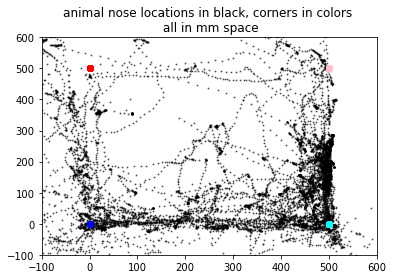

In [186]:
plt.scatter(aligned_df.nose['x'],aligned_df.nose['y'],c='k',s=1,alpha=0.5)
plt.scatter(aligned_df.box_bl['x'],aligned_df.box_bl['y'],c='r')
plt.scatter(aligned_df.box_br['x'],aligned_df.box_br['y'],c='pink')
plt.scatter(aligned_df.box_tl['x'],aligned_df.box_tl['y'],c='b')
plt.scatter(aligned_df.box_tr['x'],aligned_df.box_tr['y'],c='cyan')
plt.ylim([-100,600])
plt.xlim([-100,600])

plt.title('animal nose locations in black, corners in colors \n all in mm space')
plt.show()

### how much time did the animal spend in the box?


In [187]:
nose_vals = ~np.isnan(aligned_df.nose['x'])
ear_l_vals = ~np.isnan(aligned_df.ear_left['x'])
ear_r_vals = ~np.isnan(aligned_df.ear_right['x'])
tail_vals = ~np.isnan(aligned_df.tail_base['x'])

print("frames with nose: {}".format(np.sum(nose_vals)))
frames_with_nose = np.sum(nose_vals)
print("frames with nose and ears: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals)))
print("frames with nose and ears and tail: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals*tail_vals)))
print("total frames {}".format(len(nose_vals)))

frames with nose: 11458
frames with nose and ears: 10883
frames with nose and ears and tail: 10014
total frames 22348


C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


### how much time did it spend within 50mm of the 500mm^2 walls?


In [188]:
# can just use adj px values > 450 and < 50 (further vals are outside walls, but include jumps and rears which we do want to include)
nose_df=aligned_df.nose
#nose_df=nose_df[~np.isnan(nose_df.x)].reset_index()
nose_df['within50mm']=0
for idx in nose_df.index:
    xval=nose_df.x[idx]
    yval=nose_df.y[idx]
    if xval < 50 or xval > 450 or yval < 50 or yval > 450:
        nose_df.iloc[idx,3]=1
summed_val=np.sum(nose_df.within50mm)
print("frames with nose within 50mm of edge {}".format(summed_val))
print("fraction of frames with nose within 50mm of edge {}".format(summed_val/len(nose_df)))
print("fraction of frames where animal is inside the box AND within 50mm of an edge {}".format(summed_val/frames_with_nose))
print("fraction of frames where animal is inside and in the center (further than 50mm from an edge): {}".format((frames_with_nose-summed_val)/frames_with_nose))

C:\Users\dennise\AppData\Local\Temp\ipykernel_1236\3598521612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nose_df['within50mm']=0
C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


frames with nose within 50mm of edge 9568
fraction of frames with nose within 50mm of edge 0.4281367460175407
fraction of frames where animal is inside the box AND within 50mm of an edge 0.8350497469017281
fraction of frames where animal is inside and in the center (further than 50mm from an edge): 0.16495025309827194


### find first frame where it enters the 'center' of the box

In [189]:
tstdf=nose_df[~np.isnan(nose_df.x)]
tstdf=tstdf[tstdf.within50mm<1]
print("first frame in center (> 50mm from edge): {}".format(tstdf.index[0]))

first frame in center (> 50mm from edge): 1070


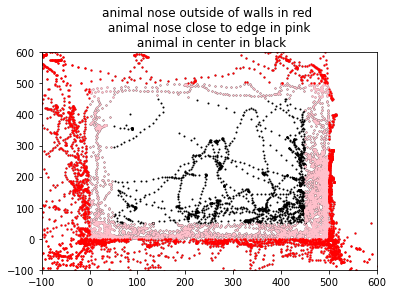

In [190]:
plt.scatter(nose_df.x,nose_df.y,s=1,c='k')
plt.scatter(nose_df.x[nose_df.x<50],nose_df.y[nose_df.x<50],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x>450],nose_df.y[nose_df.x>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.y<50],nose_df.y[nose_df.y<50],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.y>450],nose_df.y[nose_df.y>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x<0],nose_df.y[nose_df.x<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.x>500],nose_df.y[nose_df.x>500],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y<0],nose_df.y[nose_df.y<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y>500],nose_df.y[nose_df.y>500],c='r',s=1)
plt.xlim([-100,600])
plt.ylim([-100,600])
plt.title('animal nose outside of walls in red \n animal nose close to edge in pink \n animal in center in black')
plt.show()

# get distances between body points, box edges (to be used for classfiers)

In [191]:
aligned_df['dists','nose_midpoint_entrance']=float(0)
aligned_df['dists','nose_ear_right']=float(0)
aligned_df['dists','nose_ear_left']=float(0)
aligned_df['dists','nose_paw_left_back']=float(0)
aligned_df['dists','nose_paw_left_front']=float(0)
aligned_df['dists','nose_paw_right_back']=float(0)
aligned_df['dists','nose_paw_right_front']=float(0)
aligned_df['dists','nose_tail_tip']=float(0)
aligned_df['dists','nose_tail_base']=float(0)
aligned_df['speed']=float(0)
nanmean_xs=np.zeros(len(aligned_df))
nanmean_ys=np.zeros(len(aligned_df))
animal_dist_traveled=np.zeros(len(aligned_df))
entrance_x = np.mean([np.nanmean(aligned_df.opening_bottom.x),np.nanmean(aligned_df.opening_top.x)])
entrance_y = np.mean([np.nanmean(aligned_df.opening_bottom.y),np.nanmean(aligned_df.opening_top.y)])

ind_idx=-1
for idx in aligned_df.index:
    ind_idx+=1
    if idx%1000==0:
        print("on idx {} of {}".format(idx,aligned_df.index[-1]))
    rel_idx = idx-aligned_df.index[0]
    nanmean_xs[ind_idx]=np.nanmean([aligned_df.nose.x[idx],
        aligned_df.ear_left.x[idx],
        aligned_df.ear_right.x[idx],
        aligned_df.tail_base.x[idx],
        aligned_df.tail_tip.x[idx]])
    nanmean_ys[ind_idx]=np.nanmean([aligned_df.nose.y[idx],
        aligned_df.ear_left.y[idx],
        aligned_df.ear_right.y[idx],
        aligned_df.tail_base.y[idx],
        aligned_df.tail_tip.y[idx]])
    if rel_idx > 0:
        speed = math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.nose.x[idx-1],aligned_df.nose.y[idx-1]])
        animal_dist_traveled[ind_idx]=np.abs(math.dist([nanmean_xs[idx],nanmean_ys[idx]],[nanmean_xs[idx-1],nanmean_ys[idx-1]]))
    else:
        speed=0
    aligned_df.iloc[rel_idx,-1]=speed
    aligned_df.iloc[rel_idx,-2]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_base.x[idx],aligned_df.tail_base.y[idx]])
    aligned_df.iloc[rel_idx,-3]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_tip.x[idx],aligned_df.tail_tip.y[idx]])
    aligned_df.iloc[rel_idx,-4]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_front.x[idx],aligned_df.paw_right_front.y[idx]])
    aligned_df.iloc[rel_idx,-5]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_back.x[idx],aligned_df.paw_right_back.y[idx]])
    aligned_df.iloc[rel_idx,-6]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_front.x[idx],aligned_df.paw_left_front.y[idx]])
    aligned_df.iloc[rel_idx,-7]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_back.x[idx],aligned_df.paw_left_back.y[idx]])
    aligned_df.iloc[rel_idx,-8]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_left.x[idx],aligned_df.ear_left.y[idx]])
    aligned_df.iloc[rel_idx,-9]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_right.x[idx],aligned_df.ear_right.y[idx]])
    aligned_df.iloc[rel_idx,-10]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[entrance_x,entrance_y])
    

on idx 0 of 22347


C:\Users\dennise\AppData\Local\Temp\ipykernel_1236\2785288068.py:23: RuntimeWarning: Mean of empty slice
  nanmean_xs[ind_idx]=np.nanmean([aligned_df.nose.x[idx],
C:\Users\dennise\AppData\Local\Temp\ipykernel_1236\2785288068.py:28: RuntimeWarning: Mean of empty slice
  nanmean_ys[ind_idx]=np.nanmean([aligned_df.nose.y[idx],


on idx 1000 of 22347
on idx 2000 of 22347
on idx 3000 of 22347
on idx 4000 of 22347
on idx 5000 of 22347
on idx 6000 of 22347
on idx 7000 of 22347
on idx 8000 of 22347
on idx 9000 of 22347
on idx 10000 of 22347
on idx 11000 of 22347
on idx 12000 of 22347
on idx 13000 of 22347
on idx 14000 of 22347
on idx 15000 of 22347
on idx 16000 of 22347
on idx 17000 of 22347
on idx 18000 of 22347
on idx 19000 of 22347
on idx 20000 of 22347
on idx 21000 of 22347
on idx 22000 of 22347


In [192]:
aligned_df.to_csv('../../../AlexF/VID_20220722_111727DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists.csv')


## jump and rear classifications

### import annotations
- for how to import annotations from old convention/key logging, see bottom of file section called "## old annotation data from key logging used:"

In [9]:
folder_of_anns = '../../../AlexF/anns'
os.listdir(folder_of_anns)

['20210923_095848_jumps&rears.csv',
 '20210923_124032_jumps&rears.csv',
 '20210930_120132_jumps&rears.csv',
 '20220418_102137_jumps&rears.csv',
 '20220501_113258_jumps&rears.csv',
 '20220722_111727jumps&rears.csv']

In [10]:
dates_in_files = [file[0:15] for file in os.listdir(folder_of_anns)]
dates_in_files

['20210923_095848',
 '20210923_124032',
 '20210930_120132',
 '20220418_102137',
 '20220501_113258',
 '20220722_111727']

In [12]:
filename = '../../../AlexF/VID_20210923_095848DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000.csv'

In [13]:
# if running without running the rest of the notebook, switch comments and set value here, else use default
# base_fld = ?
base_fld = os.path.dirname(filename)
base_fld

'../../../AlexF'

In [14]:
subset_times = pd.read_csv('../../../AlexF/start_times_videos.csv')
subset_times


,Assay_No,File_name,Start_time_in_seconds,End_time_in_seconds,Notes
0,2,VID_20210923_095848,63,663,NaN
1,3,VID_20210923_102806,89,689,NaN
2,4,VID_20210923_110223,117,717,NaN
3,5,VID_20210923_115732,6,606,NaN
4,6,VID_20210923_124032,72,672,NaN
...,...,...,...,...,...
258,263,VID_20220927_104102,0,600,NaN
259,264,VID_20220927_110316,0,600,NaN
260,265,VID_20220927_112914,0,600,NaN
261,266,VID_20220927_114936,0,600,NaN


In [254]:
for idx in np.arange(0,len(dates_in_files)):
    date_in_file = dates_in_files[idx]
    print(date_in_file)
    file = os.listdir(folder_of_anns)[idx]
    print(file)
    ann_df = pd.read_csv(os.path.join(folder_of_anns,file))
    ann_df['frame_start']=ann_df.Time_start_raw * FPS
    ann_df['frame_end']=ann_df.Time_end_raw * FPS
    
    # find DLC file of same date
    for DLC_file in os.listdir(base_fld):
        if date_in_file in DLC_file and "aligned_dist" in DLC_file and 'jumps' not in DLC_file:
            print(DLC_file)
            full_DLC_path=os.path.join(base_fld,DLC_file)
            adj_df = pd.read_csv(full_DLC_path,header=[0,1],index_col=0)
    print(full_DLC_path)
    # get start frame, end frame and add to ann_df
    adj_df_anns=np.zeros(len(adj_df))
    for ann_idx in ann_df.index:
        if "ump" in ann_df.Behavior[ann_idx]:
            val = 1
        else:
            val=2
        adj_df_anns[int(np.floor(ann_df.frame_start[ann_idx])):int(np.ceil(ann_df.frame_end[ann_idx]))]=val
    adj_df['anns']=adj_df_anns
    
    for file_nm in subset_times.File_name:
        if file_nm in full_DLC_path:
            start_val = int(np.round(subset_times.Start_time_in_seconds[subset_times.File_name==file_nm]*FPS))
            end_val= int(np.round(subset_times.End_time_in_seconds[subset_times.File_name==file_nm]*FPS))
            print(start_val,end_val)
            adj_df_sub=adj_df[start_val:end_val].reset_index().drop(columns=['index'])
    adj_df_sub.to_csv(full_DLC_path[0:-4]+"_withjumps.csv")

20210923_095848
20210923_095848_jumps&rears.csv
VID_20210923_095848DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists.csv
../../../AlexF\VID_20210923_095848DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists.csv
1886 19844
20210923_124032
20210923_124032_jumps&rears.csv
VID_20210923_124032DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists.csv
../../../AlexF\VID_20210923_124032DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists.csv
2155 20113
20210930_120132
20210930_120132_jumps&rears.csv
VID_20210930_120132DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists.csv
../../../AlexF\VID_20210930_120132DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists.csv
90 18048
20220418_102137
20220418_102137_jumps&rears.csv
VID_20220418_102137DLC_resnet50_2022_Knowles_AlexOct13shuffle1_2500000_aligned_dists.csv
../../../AlexF\VID_20220418_102137DLC_resnet50_2022_Knowles_AlexOct13shuffle1_2500000_aligned_dists.csv
120 18078
2

In [276]:
adj_df_sub=pd.read_csv('../../../AlexF/VID_20220418_102137DLC_resnet50_2022_Knowles_AlexOct13shuffle1_2500000_aligned_dists_withjumps.csv',header=[0,1])
adj_df_sub

Unnamed: 0_level_0        box_bl                   box_br         \
      Unnamed: 0_level_1             x      y likelihood      x      y   
0                      0  0.000000e+00  500.0   0.990623  500.0  500.0   
1                      1  0.000000e+00  500.0   0.991499  500.0  500.0   
2                      2 -1.150515e-13  500.0   0.993656  500.0  500.0   
3                      3 -5.752336e-14  500.0   0.993916  500.0  500.0   
4                      4  5.749771e-14  500.0   0.993786  500.0  500.0   
...                  ...           ...    ...        ...    ...    ...   
17953              17953  0.000000e+00  500.0   0.996283  500.0  500.0   
17954              17954 -5.757184e-14  500.0   0.996333  500.0  500.0   
17955              17955  1.151429e-13  500.0   0.996307  500.0  500.0   
17956              17956 -1.151427e-13  500.0   0.996432  500.0  500.0   
17957              17957  0.000000e+00  500.0   0.996481  500.0  500.0   

                        box_tl                           ...          dists  \
      likelihood             x             y likelihood  ... nose_ear_right   
0       0.985134  0.000000e+00  3.536538e-14   0.988898  ...            NaN   
1       0.979719  5.658521e-14  0.000000e+00   0.989780  ...            NaN   
2       0.985756 -5.658917e-14  1.414729e-14   0.987088  ...            NaN   
3       0.986255 -5.659087e-14 -4.244315e-14   0.992676  ...            NaN   
4       0.985996  5.660118e-14 -2.122544e-14   0.992439  ...            NaN   
...          ...           ...           ...        ...  ...            ...   
17953   0.988722  5.664415e-14  0.000000e+00   0.993801  ...            NaN   
17954   0.990246  0.000000e+00  7.080495e-15   0.993636  ...            NaN   
17955   0.989719  5.664363e-14  4.248272e-14   0.993330  ...            NaN   
17956   0.989240 -5.664342e-14 -2.832171e-14   0.994077  ...            NaN   
17957   0.989785  5.664331e-14  7.080413e-15   0.994460  ...            NaN   

                                                            \
      nose_ear_left nose_paw_left_back nose_paw_left_front   
0               NaN                NaN                 NaN   
1               NaN                NaN                 NaN   
2               NaN                NaN                 NaN   
3               NaN                NaN                 NaN   
4               NaN                NaN                 NaN   
...             ...                ...                 ...   
17953           NaN                NaN                 NaN   
17954           NaN                NaN                 NaN   
17955           NaN                NaN                 NaN   
17956           NaN                NaN                 NaN   
17957           NaN                NaN                 NaN   

                                                                             \
      nose_paw_right_back nose_paw_right_front nose_tail_tip nose_tail_base   
0                     NaN                  NaN           NaN            NaN   
1                     NaN                  NaN           NaN            NaN   
2                     NaN                  NaN           NaN            NaN   
3                     NaN                  NaN           NaN            NaN   
4                     NaN                  NaN           NaN            NaN   
...                   ...                  ...           ...            ...   
17953                 NaN                  NaN           NaN            NaN   
17954                 NaN                  NaN           NaN            NaN   
17955                 NaN                  NaN           NaN            NaN   
17956                 NaN                  NaN           NaN            NaN   
17957                 NaN                  NaN           NaN            NaN   

                    speed                anns  
      Unnamed: 55_level_1 Unnamed: 56_level_1  
0                     NaN                 0.0  
1                     NaN           

(-100.0, 600.0)

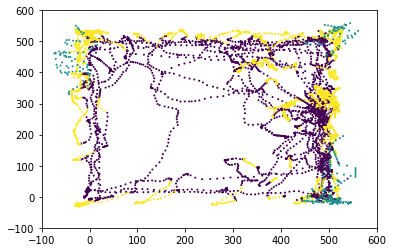

In [277]:
plt.scatter(adj_df_sub.nose.x,adj_df_sub.nose.y,c=adj_df_sub.anns['Unnamed: 56_level_1'],s=1)
plt.xlim([-100,600])
plt.ylim([-100,600])

In [15]:
# make one large training/test dataset, excluding last file for now, will use it for testing
file_list = [file for file in os.listdir(base_fld) if "withjumps" in file]
file_list

['VID_20210923_095848DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists_withjumps.csv',
 'VID_20210923_124032DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists_withjumps.csv',
 'VID_20210930_120132DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists_withjumps.csv',
 'VID_20220418_102137DLC_resnet50_2022_Knowles_AlexOct13shuffle1_2500000_aligned_dists_withjumps.csv',
 'VID_20220501_113258DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists_withjumps.csv',
 'VID_20220722_111727DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000_aligned_dists_withjumps.csv']

In [59]:
for idx in np.arange(0,len(file_list)-1):
    df = pd.read_csv(os.path.join(base_fld,file_list[idx]),header=[0,1])
    if idx==0:
        all_anns = df.copy()
    else:
        all_anns = pd.concat([all_anns,df.copy()])
    print(len(all_anns))

17958
35916
53874
71832
89790


In [60]:
all_anns=all_anns.drop(columns='Unnamed: 0_level_0')
all_anns

C:\Users\dennise\Anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.984704  500.0  500.0   0.974739  7.190792e-15   
1     -7.356319e-15  500.0   0.982959  500.0  500.0   0.979645 -7.190795e-15   
2     -7.356994e-15  500.0   0.983568  500.0  500.0   0.980381  3.595495e-15   
3      0.000000e+00  500.0   0.981647  500.0  500.0   0.965523  0.000000e+00   
4      7.358285e-15  500.0   0.987533  500.0  500.0   0.962255  7.191294e-15   
...             ...    ...        ...    ...    ...        ...           ...   
17953  3.685297e-15  500.0   0.978973  500.0  500.0   0.835657  0.000000e+00   
17954  1.105583e-14  500.0   0.969021  500.0  500.0   0.836974  7.206252e-15   
17955 -7.370479e-15  500.0   0.977024  500.0  500.0   0.834068  0.000000e+00   
17956  3.685204e-15  500.0   0.968560  500.0  500.0   0.837446  1.080929e-14   
17957  1.105541e-14  500.0   0.971802  500.0  500.0   0.838634  1.080922e-14   

                               box_tr  ...          dists                \
                  y likelihood      x  ... nose_ear_right nose_ear_left   
0     -2.876317e-14   0.993223  500.0  ...            NaN           NaN   
1      0.000000e+00   0.993215  500.0  ...            NaN           NaN   
2     -2.876396e-14   0.992705  500.0  ...            NaN           NaN   
3      0.000000e+00   0.992042  500.0  ...            NaN           NaN   
4      0.000000e+00   0.991750  500.0  ...            NaN           NaN   
...             ...        ...    ...  ...            ...           ...   
17953  1.153003e-13   0.925364  500.0  ...      18.981828     19.890250   
17954  5.765002e-14   0.929383  500.0  ...      15.211631     17.107351   
17955  0.000000e+00   0.938096  500.0  ...      16.189244     18.485619   
17956  0.000000e+00   0.936909  500.0  ...      19.597012     21.252085   
17957  5.764916e-14   0.933958  500.0  ...      21.555435     22.943560   

                                                                  \
      nose_paw_left_back nose_paw_left_front nose_paw_right_back   
0                    NaN                 NaN                 NaN   
1                    NaN                 NaN                 NaN   
2                    NaN                 NaN                 NaN   
3                    NaN                 NaN                 NaN   
4                    NaN                 NaN                 NaN   
...                  ...                 ...                 ...   
17953                NaN                 NaN                 NaN   
17954                NaN                 NaN                 NaN   
17955                NaN                 NaN                 NaN   
17956                NaN                 NaN                 NaN   
17957                NaN                 NaN                 NaN   

                                                                      speed  \
      nose_paw_right_front nose_tail_tip nose_tail_base Unnamed: 55_level_1   
0                      NaN           NaN            NaN                 NaN   
1                      NaN           NaN            NaN                 NaN   
2                      NaN           NaN            NaN                 NaN   
3                      NaN           NaN            NaN                 NaN   
4                      NaN           NaN            NaN                 NaN   
...                    ...           ...            ...                 ...   
17953                  NaN     65.525934      58.893289            6.008337   
17954                  NaN     64.502745      57.411486            2.255582   
17955                  NaN     63.467161      59.594931            3.013172   
17956                  NaN     60.468188      62.270321            5.709567   
17957                  NaN     57.523410      64.179180            4.592175   

                     anns  
      Unnamed: 56_level_1  
0                     0.0  

In [61]:
all_anns=all_anns.reset_index().drop(columns='index')

C:\Users\dennise\Anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## building a classifier

In [62]:
all_anns.columns

MultiIndex([(         'box_bl',                      'x'),
            (         'box_bl',                      'y'),
            (         'box_bl',             'likelihood'),
            (         'box_br',                      'x'),
            (         'box_br',                      'y'),
            (         'box_br',             'likelihood'),
            (         'box_tl',                      'x'),
            (         'box_tl',                      'y'),
            (         'box_tl',             'likelihood'),
            (         'box_tr',                      'x'),
            (         'box_tr',                      'y'),
            (         'box_tr',             'likelihood'),
            (       'ear_left',                      'x'),
            (       'ear_left',                      'y'),
            (       'ear_left',             'likelihood'),
            (      'ear_right',                      'x'),
            (      'ear_right',                      'y'

### make training and test data

In [63]:
df_for_training=pd.concat([all_anns['nose']['x'],all_anns['nose','y'],all_anns['nose']['likelihood'],all_anns['tail_base']['likelihood'],all_anns['paw_left_back']['likelihood'],all_anns['paw_right_back']['likelihood'],all_anns.dists['nose_midpoint_entrance'],all_anns.dists['nose_tail_base'],all_anns.speed['Unnamed: 55_level_1']],axis=1)
df_for_training.columns=['nose_x','nose_y','nose_likelihood','tail_base_likelihood','paw_lb_likelihood','paw_rb_likelihood','dists_fromentrance','dists_nose_tail_base','speed']
df_for_training

,nose_x,nose_y,nose_likelihood,tail_base_likelihood,paw_lb_likelihood,paw_rb_likelihood,dists_fromentrance,dists_nose_tail_base,speed
0,NaN,NaN,0.081262,0.056196,0.086395,0.172087,NaN,NaN,NaN
1,NaN,NaN,0.080120,0.051517,0.083888,0.170420,NaN,NaN,NaN
2,NaN,NaN,0.090188,0.053773,0.081936,0.171772,NaN,NaN,NaN
3,NaN,NaN,0.090767,0.052270,0.078850,0.174372,NaN,NaN,NaN
4,NaN,NaN,0.092486,0.049784,0.071847,0.167006,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
89785,87.968025,367.490997,0.993415,0.980944,0.284822,0.469150,385.895397,58.893289,6.008337
89786,90.220612,367.374786,0.990701,0.970195,0.273738,0.448331,384.940467,57.411486,2.255582
89787,88.264923,369.667053,0.979520,0.966834,0.251345,0.458526,387.798645,59.594931,3.013172
89788,85.580681,374.706299,0.997315,0.969129,0.252062,0.436261,393.477801,62.270321,5.709567


In [64]:
df_for_training_annots=all_anns.anns['Unnamed: 56_level_1']
df_for_training_annots

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
89785    2.0
89786    2.0
89787    0.0
89788    0.0
89789    0.0
Name: Unnamed: 56_level_1, Length: 89790, dtype: float64

In [65]:
# scale only speed, x, y, dists
for col in ['nose_x','nose_y','dists_fromentrance','dists_nose_tail_base','speed']:
    min_val = np.nanmin(df_for_training[col])
    if min_val < 0:
        add_val = np.abs(min_val)
    else:
        add_val=0
    maxval=np.nanmax(df_for_training[col])
    df_for_training[col]=np.add(df_for_training[col],add_val)/np.nanmax(df_for_training[col])
    print(add_val)
    print(np.nanmax(df_for_training[col]))

73.40971374511719
1.127447797832313
177.7734375
1.2860249664961794
0
1.0
0
1.0
0
1.0


In [66]:
# True, None, gini, None, auto, None, 1, 2, 0, 100, 4, False, 0, 1, True
    # 14380, 41, 148
    # 114, 563, 31
    # 265, 10, 2376

# True, None, gini, None, auto, None, 1, 20, 0, 200, 4, False, 0, 1, True
    # 143234  48, 197
    # 150, 557, 31
    # 326, 12, 2313
    
# True, None, gini, None, auto, None, 10, 20, 0, 200, 4, False, 0, 1, True
    # worse for all   
    
# True, None, gini, None, auto, None, 1, 2, 0, 200, 4, False, 0, 1, True
    # 14370, 42, 157
    # 138, 575, 25
    # 270, 9 2372
    
# True, None, entropy, None, auto, None, 1, 2, 0, 100, 4, False, 0, 1, True
    # slightly worse
    
# True, None, gini, None, auto, None, 1, 2, 0, 100, 4, True, 0, 1, False
    # does nothing

In [67]:
xVar=df_for_training.columns
yVar=df_for_training_annots
df_for_training=df_for_training.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(df_for_training, yVar, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(71832, 9) (71832,)
(17958, 9) (17958,)


# try random forest

In [565]:
clf = RandomForestClassifier(bootstrap=True, 
            class_weight=None, 
            criterion='gini',
            max_depth=None, 
            max_features='auto', 
            max_leaf_nodes=None,
            min_samples_leaf=1,
            min_samples_split=2, 
            min_weight_fraction_leaf=0.0,
            n_estimators=100, 
            n_jobs=4, 
            oob_score=False,
            random_state=0,
            verbose=1, 
            warm_start=False)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Predicted Result,0.0,1.0,2.0
Actual Result,,,
0.0,14412,56,203
1.0,117,572,26
2.0,304,14,2254


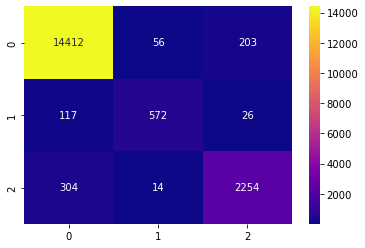

In [568]:
cm = pd.DataFrame(confusion_matrix(y_test, preds))
sns.heatmap(cm, annot=True, fmt='d',cmap='plasma');

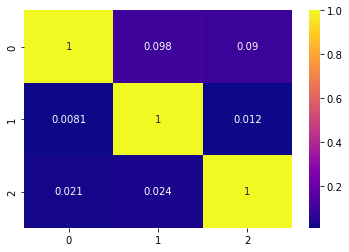

In [569]:
for col in cm.columns:
    cm[col]=np.divide(cm[col],np.max(cm[col]))

sns.heatmap(cm, annot=True,cmap='plasma');

In [633]:
acc =  clf.score(X_test, y_test)
acc

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9599064483795523

In [506]:
list(zip(X_train, clf.feature_importances_))

[('nose_x', 0.12392191861380267),
 ('nose_y', 0.12259825946801743),
 ('nose_likelihood', 0.08947124670449898),
 ('tail_base_likelihood', 0.15153926686658667),
 ('paw_lb_likelihood', 0.06303941386529001),
 ('paw_rb_likelihood', 0.11730406312271438),
 ('dists_fromentrance', 0.10743029720498923),
 ('dists_nose_tail_base', 0.14113413641527375),
 ('speed', 0.08356139773882686)]

In [ ]:
import joblib
joblib.dump(clf, '../data/20230216_RF_jumps.pkl') 

In [583]:
clf = joblib.load('../data/20230216_RF_jumps.pkl')

In [318]:
#clf = joblib.load('../data/20221219_RF_jumps.pkl')

In [507]:
preds_to_plot=clf.predict(df_for_training.fillna(0))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

Text(0.5, 1.0, 'predicted in darker blues')

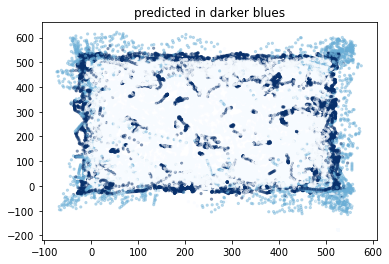

In [572]:
plt.scatter(all_anns.nose.x,all_anns.nose.y,c=preds_to_plot,cmap="Blues",s=5,alpha=.4)
#
plt.clim([0,2])
plt.title('predicted in darker blues')

Text(0.5, 1.0, 'ground truth in darker blues')

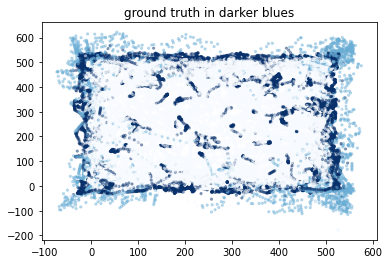

In [571]:
plt.scatter(all_anns.nose.x,all_anns.nose.y,c=yVar,cmap="Blues",s=5,alpha=.4)
plt.clim([0,2])
plt.title('ground truth in darker blues')

Text(0.5, 1.0, 'predicted in yellow, ground truth in cyan')

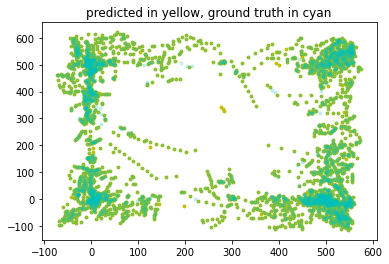

In [514]:
plt.scatter(all_anns.nose.x[preds_to_plot==1],all_anns.nose.y[preds_to_plot==1],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==1],all_anns.nose.y[yVar==1],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')

Text(0.5, 1.0, 'predicted in yellow, ground truth in cyan')

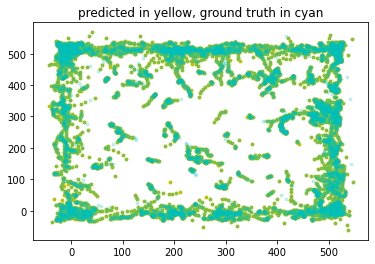

In [515]:
plt.scatter(all_anns.nose.x[preds_to_plot==2],all_anns.nose.y[preds_to_plot==2],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==2],all_anns.nose.y[yVar==2],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')

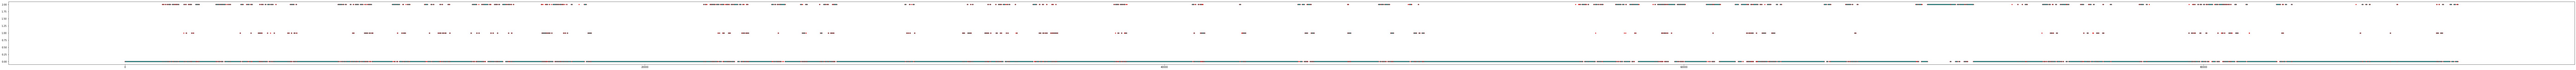

In [576]:
plt.figure(figsize=(200,5))
plt.scatter(np.arange(0,len(preds_to_plot)),preds_to_plot,c='r',s=10)
plt.scatter(np.arange(0,len(preds_to_plot)),df_for_training_annots,c='c',alpha=0.05,s=10)
#plt.xlim(15000,20000)
plt.show()

In [537]:
# list features, their contribution
list(zip(X_train, clf.feature_importances_))

[('nose_x', 0.12392191861380267),
 ('nose_y', 0.12259825946801743),
 ('nose_likelihood', 0.08947124670449898),
 ('tail_base_likelihood', 0.15153926686658667),
 ('paw_lb_likelihood', 0.06303941386529001),
 ('paw_rb_likelihood', 0.11730406312271438),
 ('dists_fromentrance', 0.10743029720498923),
 ('dists_nose_tail_base', 0.14113413641527375),
 ('speed', 0.08356139773882686)]

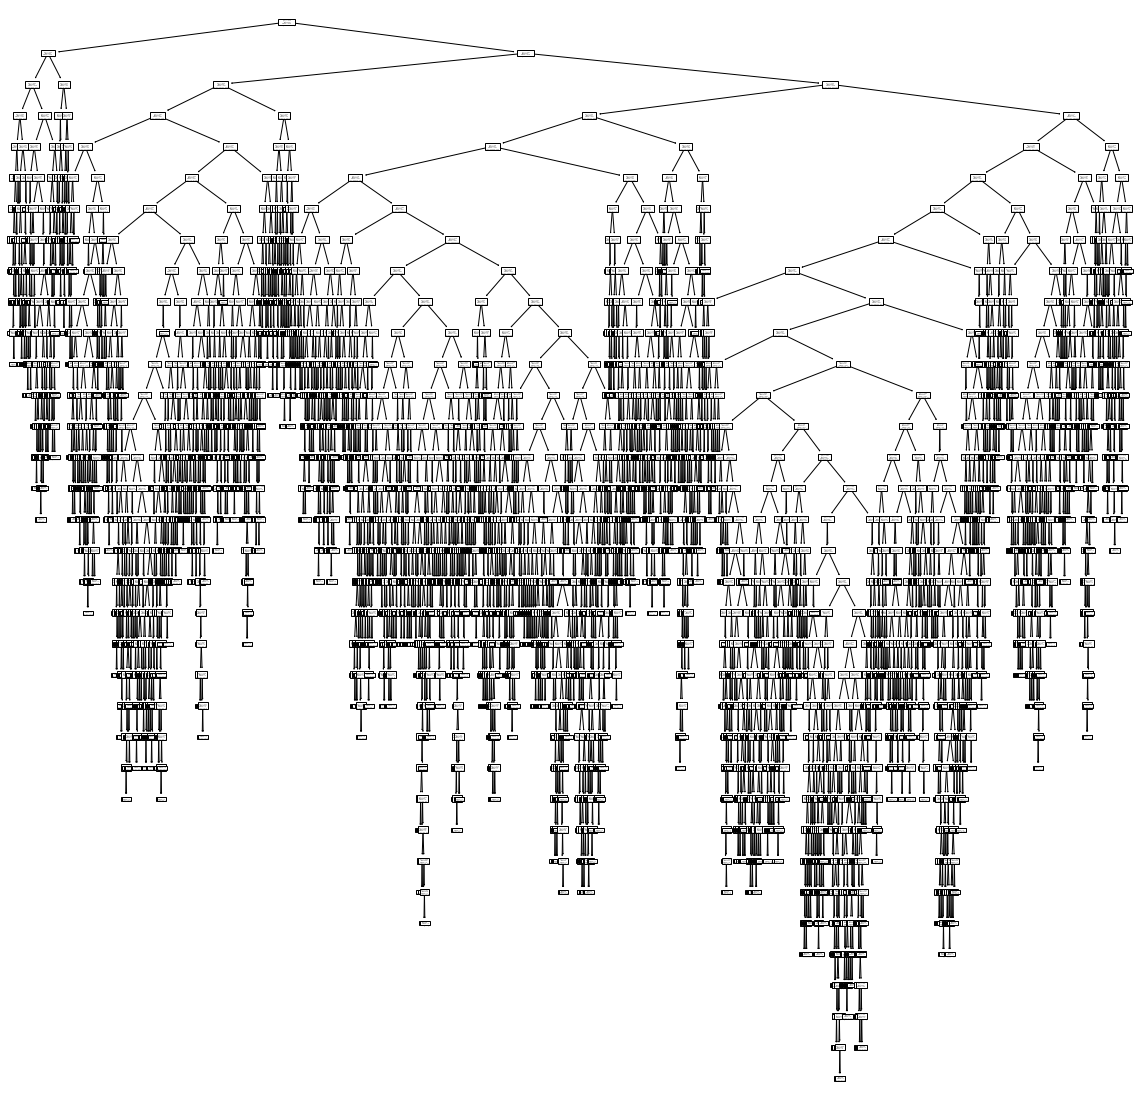

In [577]:
from sklearn import tree

plt.figure(figsize=(20,20))
_=tree.plot_tree(clf.estimators_[0])
plt.savefig('/Users/dennise/Desktop/DT_jumps_for_Alex.eps')

In [634]:
for num in [0,1,2,3,4,5,6,7,8,9,10]:
    print(num)
    _=tree.plot_tree(clf.estimators_[num], feature_names=X_train.columns,label='none',filled=True,impurity=False)
    pd.DataFrame(_).to_csv('../data/DT_{}.csv'.format(num))
    print('done with {}'.format(num))

0
done with 0
1
done with 1
2
done with 2
3
done with 3
4
done with 4
5
done with 5
6
done with 6
7
done with 7
8
done with 8
9
done with 9
10
done with 10
Error in callback <function flush_figures at 0x00000252BE82E040> (for post_execute):



KeyboardInterrupt



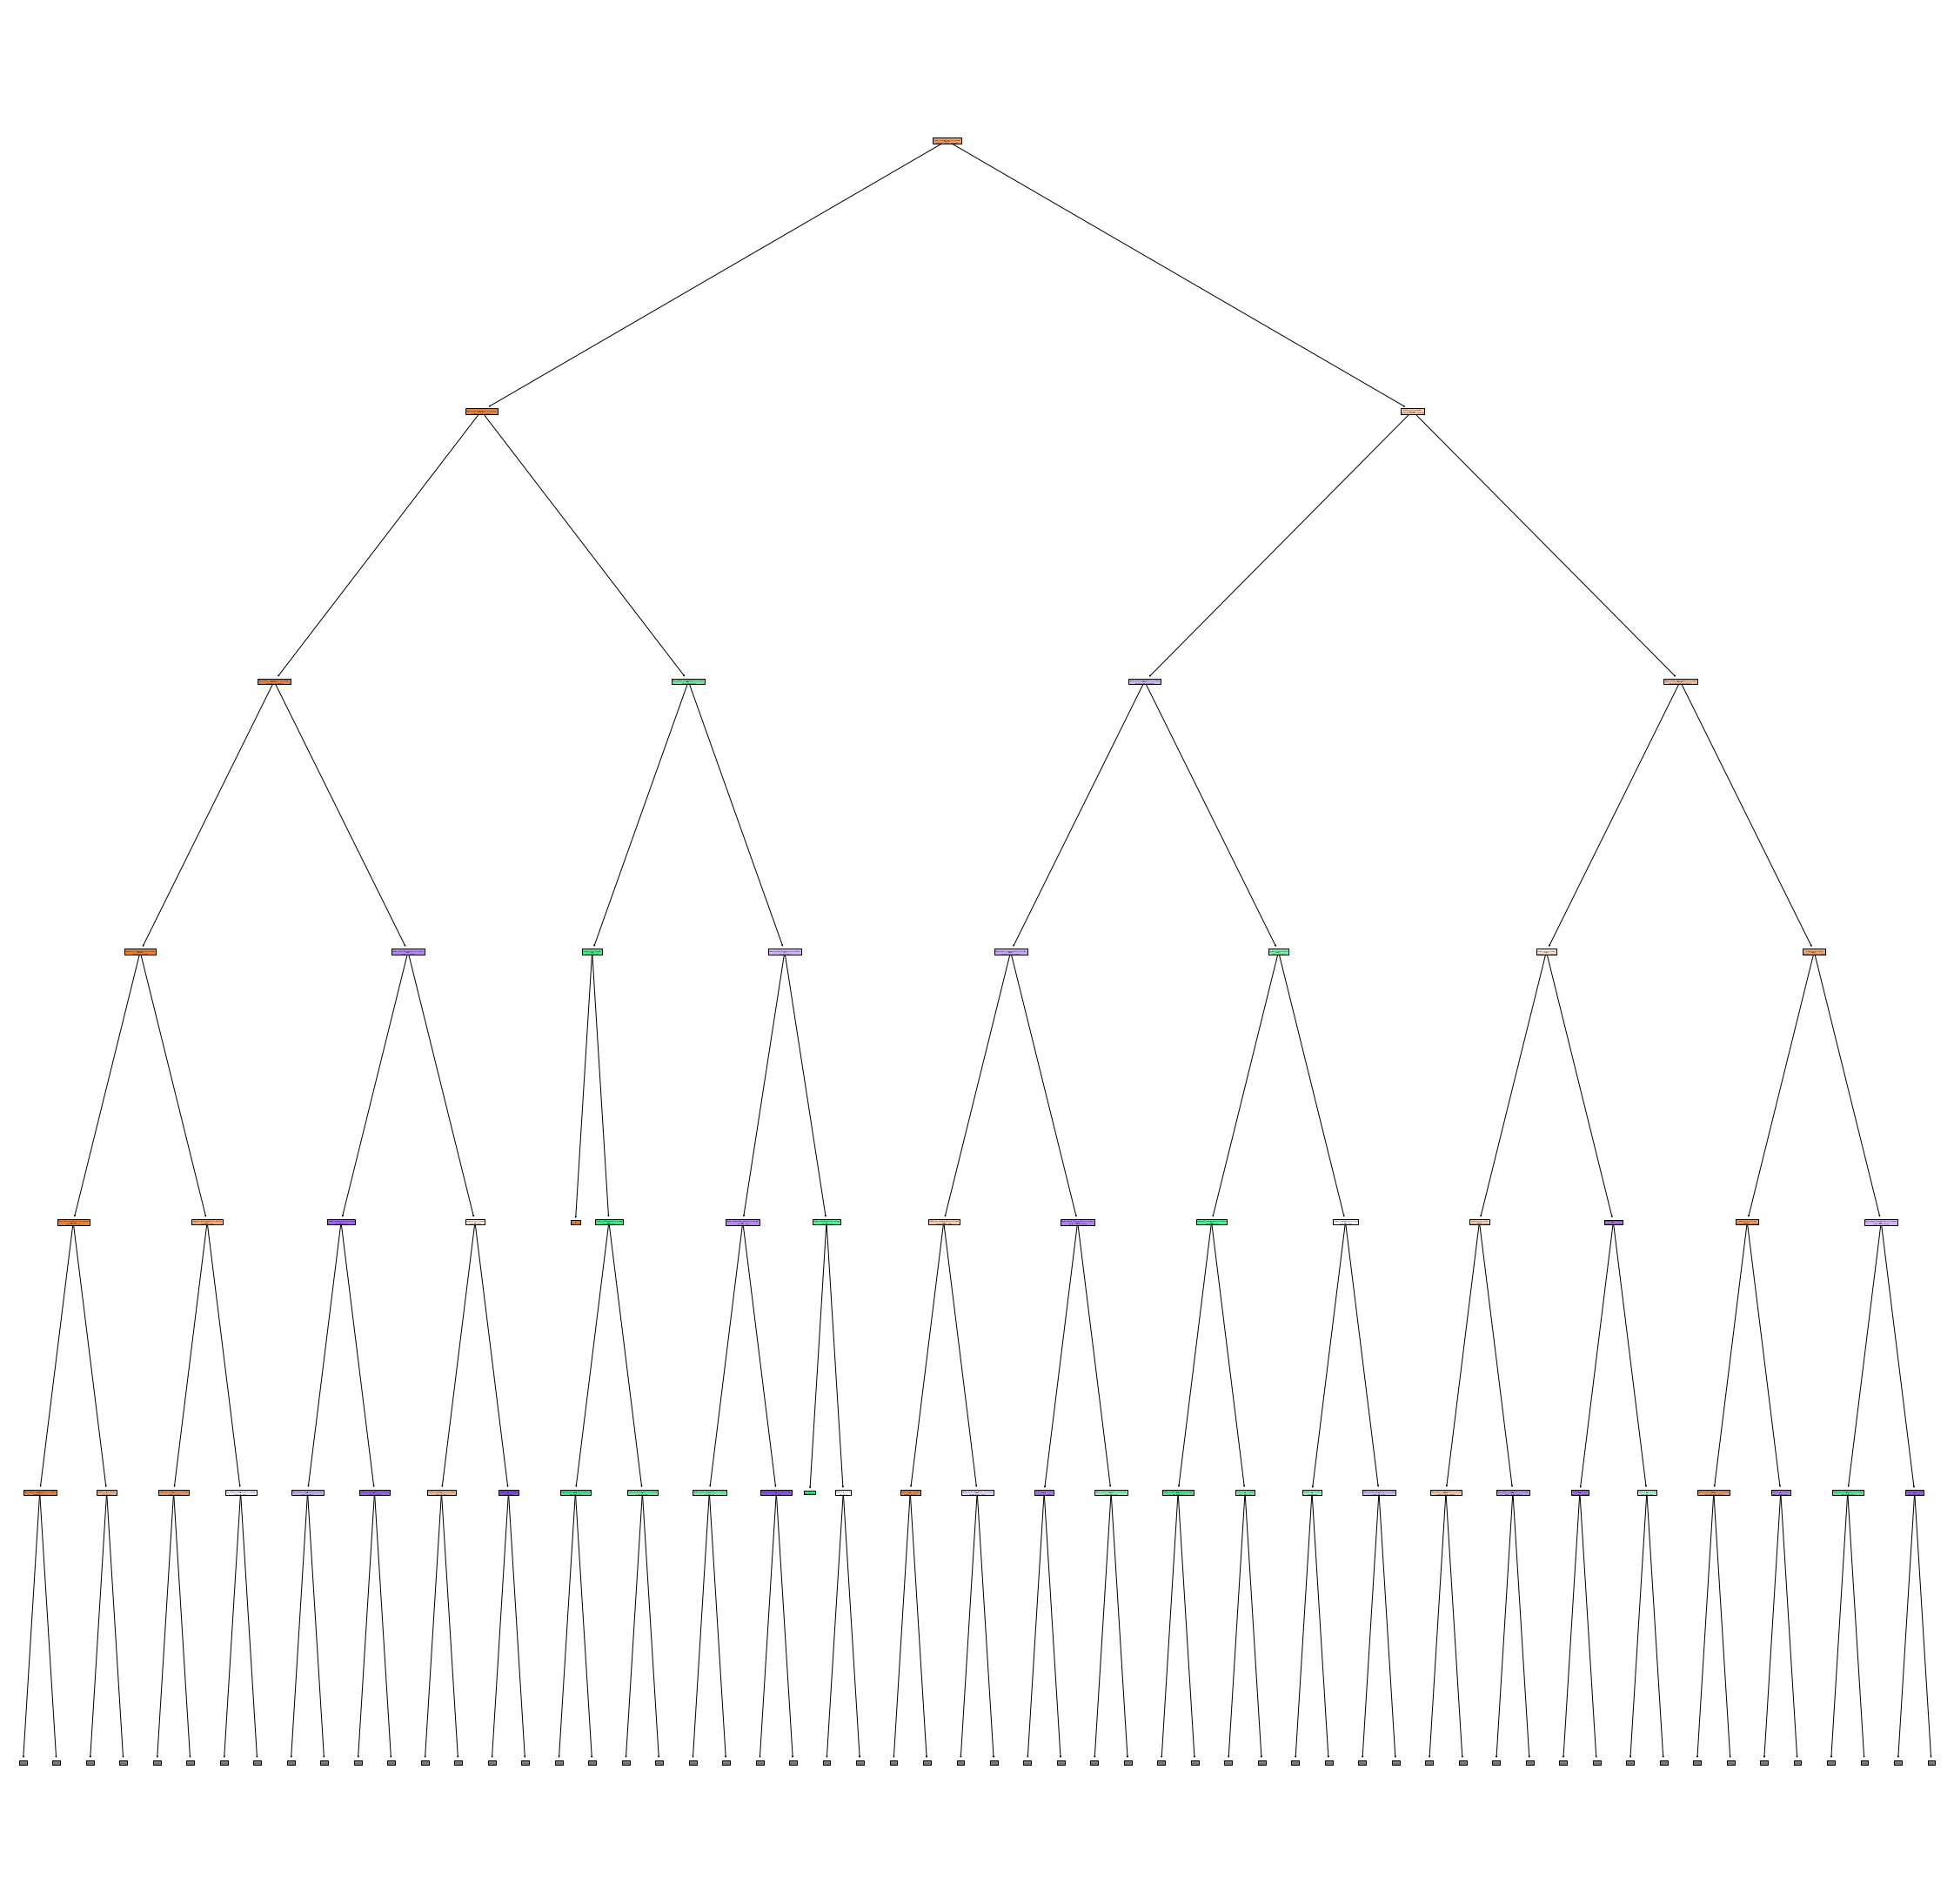

In [625]:
plt.figure(figsize=(40,40))
max_depth=3
_ = tree.plot_tree(clf.estimators_[0], feature_names=X_train.columns,max_depth=max_depth,label='none',filled=True,impurity=False)
#plt.savefig('/Users/dennise/Desktop/DT_jumps_for_Alex_TOP{}.png'.format(max_depth))

# trying kmeans (independent verification)

In [539]:
for n in [2,3,4,5,10,20,100]:
    classifier = KNeighborsClassifier(n_neighbors=n)
    classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_test)
    acc =  classifier.score(X_test, y_test)
    print(n,acc)

2 0.9432008018710324
3 0.947043100567992
4 0.944537253591714
5 0.9457066488473104
10 0.9352934625236663
20 0.926383784385789
100 0.898875153135093


In [540]:
n=3
classifier = KNeighborsClassifier(n_neighbors=n)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc =  classifier.score(X_test, y_test)

In [580]:
joblib.dump(classifier, '../data/20230216_Kmeans_jumpsrears.pkl') 
clf = joblib.load('../data/20230216_Kmeans_jumpsrears.pkl')

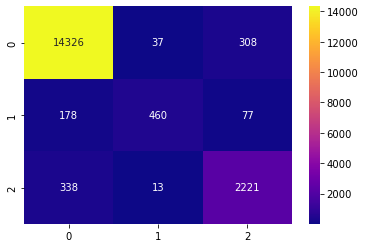

In [563]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d',cmap='plasma');

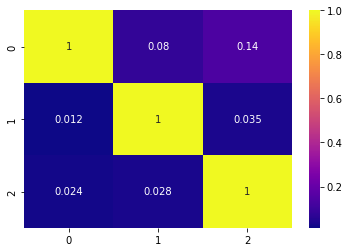

In [564]:
for col in cm.columns:
    cm[col]=np.divide(cm[col],np.max(cm[col]))

sns.heatmap(cm, annot=True,cmap='plasma');

# using the predictions

In [68]:
clf=joblib.load('../data/20230216_RF_jumps.pkl')

C:\Users\dennise\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\dennise\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [69]:
preds_to_plot=clf.predict(df_for_training.fillna(0))


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


In [107]:
jump_num=0
rear_num=0
jump_num_ann_comp=np.zeros(len(preds_to_plot))
rear_num_ann_comp=np.zeros(len(preds_to_plot))

for idx in np.arange(4,len(preds_to_plot)):
    if preds_to_plot[idx]==1:
        if 1 not in np.unique(preds_to_plot[idx-4:idx]):
            jump_num+=1
        jump_num_ann_comp[idx]=jump_num
    elif preds_to_plot[idx]==2:
        if 2 not in np.unique(preds_to_plot[idx-4:idx]):
            rear_num+=1
        rear_num_ann_comp[idx]=rear_num        
print(np.max(jump_num_ann_comp),np.max(rear_num_ann_comp))

282.0 444.0


In [85]:
jump_num=0
jump_num_ann=np.zeros(len(preds_to_plot))
for idx in np.arange(1,len(df_for_training_annots)):
    if df_for_training_annots[idx]==1:
        if df_for_training_annots[idx-1]!=1:
            jump_num+=1
        jump_num_ann[idx]=jump_num
        
rear_num=0
rear_num_ann=np.zeros(len(preds_to_plot))
for idx in np.arange(1,len(df_for_training_annots)):
    if df_for_training_annots[idx]==2:
        if df_for_training_annots[idx-1]!=2:
            rear_num+=1
        rear_num_ann[idx]=rear_num

array([0., 0., 0., ..., 0., 0., 0.])

(120.0, 140.0)

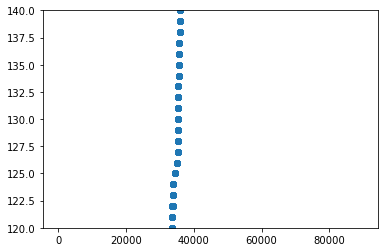

In [94]:
plt.scatter(np.arange(0,len(jump_num_ann)),jump_num_ann)
#plt.xlim(34000,37000)
plt.ylim(120,140)

In [95]:
maxval=0
for val in np.unique(jump_num_ann)[1:]:
    if len(jump_num_ann[jump_num_ann==val]) > maxval:
        maxval=len(jump_num_ann[jump_num_ann==val])
        print(val, maxval)

1.0 15
44.0 17
46.0 19


In [97]:
df_for_training['jumpnumanns']=jump_num_ann
df_for_training.to_csv('/Users/dennise/Desktop/tst.csv')
df_for_training

,nose_x,nose_y,nose_likelihood,tail_base_likelihood,paw_lb_likelihood,paw_rb_likelihood,dists_fromentrance,dists_nose_tail_base,speed,jumpnumanns
0,0.000000,0.000000,0.081262,0.056196,0.086395,0.172087,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.080120,0.051517,0.083888,0.170420,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.090188,0.053773,0.081936,0.171772,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.090767,0.052270,0.078850,0.174372,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.092486,0.049784,0.071847,0.167006,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
89785,0.280171,0.877292,0.993415,0.980944,0.284822,0.469150,0.563560,0.314566,0.009363,0.0
89786,0.284081,0.877105,0.990701,0.970195,0.273738,0.448331,0.562165,0.306652,0.003515,0.0
89787,0.280686,0.880793,0.979520,0.966834,0.251345,0.458526,0.566340,0.318314,0.004695,0.0
89788,0.276026,0.888901,0.997315,0.969129,0.252062,0.436261,0.574633,0.332604,0.008897,0.0


In [98]:
print(jump_num,rear_num)

266 373


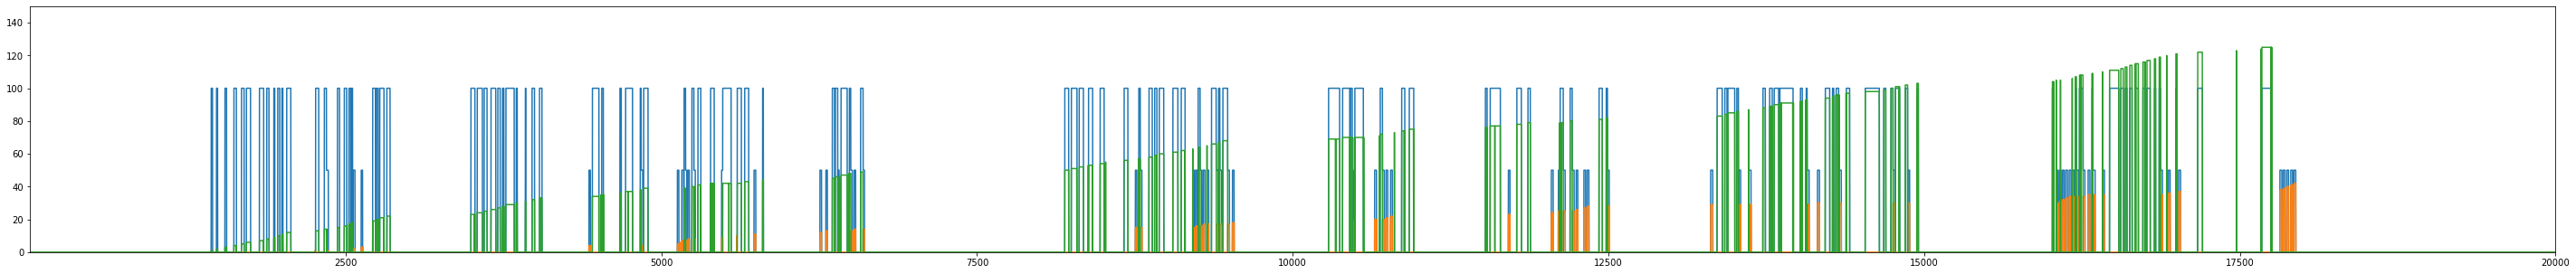

In [99]:
plt.figure(figsize=(50,5))
plt.plot(all_anns.anns*50)
plt.plot(jump_num_ann_comp)
plt.plot(rear_num_ann_comp)
plt.xlim(1,20000)
plt.ylim(0,150)
plt.show()

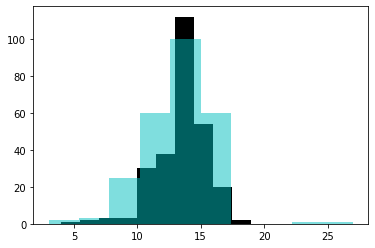

In [108]:
ann_jump_lens=[]
for val in np.arange(0,np.max(jump_num_ann)):
    ann_jump_lens.append(len(jump_num_ann[jump_num_ann==val]))
plt.hist(ann_jump_lens[1:],color='k')

comp_jump_lens=[]
for val in np.arange(0,np.max(jump_num_ann_comp)):
    len_val=len(jump_num_ann_comp[jump_num_ann_comp==val])
    if len_val < 3:
        jump_num_ann_comp[jump_num_ann_comp==val]=0
        jump_num_ann_comp[jump_num_ann_comp>val]-=1
    else:
        comp_jump_lens.append(len_val)
plt.hist(comp_jump_lens[1:],color='c',alpha=0.5)
plt.show()

In [101]:
len(np.unique(jump_num_ann))

267

In [102]:
len(np.unique(jump_num_ann_comp))

162

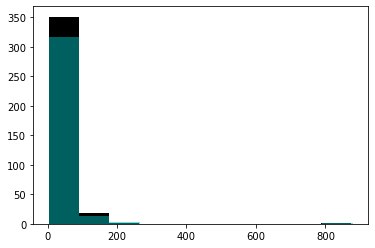

In [109]:
ann_rear_lens=[]
for val in np.arange(0,np.max(rear_num_ann)):
    ann_rear_lens.append(len(rear_num_ann[rear_num_ann==val]))
plt.hist(ann_rear_lens[1:],color='k')

comp_rear_lens=[]
for val in np.arange(0,np.max(rear_num_ann_comp)):
    len_val=len(rear_num_ann_comp[rear_num_ann_comp==val])
    if len_val < 3:
        rear_num_ann_comp[rear_num_ann_comp==vasl]=0
        rear_num_ann_comp[rear_num_ann_comp>val]-=1
    else:
        comp_rear_lens.append(len_val)
plt.hist(comp_rear_lens[1:],color='c',alpha=0.5)
plt.show()

In [685]:
len(np.unique(rear_num_ann_comp))

359

In [686]:
len(np.unique(rear_num_ann))

354

## old annotation data from key logging used:

```
Alex_annot_filename = '../data/boris_events_{}_just_jumps.csv'.format(num)
annots=pd.read_csv(Alex_annot_filename,header=0)
aligned_df=pd.read_csv(filename[:-4]+"_aligned_dists.csv",header=[0,1],index_col=0)
annots


annots['frame_start']=annots.Time_start_new*annots.FPS
annots['frame_end']=annots.Time_end_new*annots.FPS

times = pd.read_csv('../../../AlexF/start_times_videos.csv')

aligned_df['in_box']=float(0)
aligned_df['light_bout_num']=float(0)
bout_num=0
for idx in aligned_df.index:
    if np.isnan(aligned_df.nose.x[idx]):
        aligned_df.iloc[idx,-2]=0
        aligned_df.iloc[idx,-1]=0
    elif aligned_df.iloc[idx-1,-2]==0:
        bout_num+=1
        aligned_df.iloc[idx,-2]=1
        aligned_df.iloc[idx,-1]=bout_num
    else:
        aligned_df.iloc[idx,-2]=1
        aligned_df.iloc[idx,-1]=bout_num
        
annots_in_box=annots[annots.Behavior=='Light'].reset_index()
aligned_df['annots','in_light']=float(0)
aligned_df

fps=annots.FPS[0]
aligned_df['annots','in_light']=0

for idx in np.arange(0,len(annots_in_box),2):
    print(annots_in_box.Time[idx])
    val1=int(round(annots_in_box.adj_frame[idx]))
    val2=int(round(annots_in_box.adj_frame[idx+1]))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df
```

## building a classifier, random forest OLD

In [50]:
# make subsetted dataframe with just jumps
annots_jumps=pd.DataFrame()

for idx in annots.index:
    if "ump" in annots.Behavior[idx]:
        annots_jumps=pd.concat([annots_jumps,annots[annots.index==idx]],axis=0)

annots_jumps=annots_jumps.reset_index().drop(columns='index')
aligned_df['annots','jumps']=float(0)
for idx in np.arange(0,len(annots_jumps)):
    val1=int(round(annots_jumps.adj_frame[idx]-1))
    val2=int(round(annots_jumps.adj_frame[idx]+5))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999807  500.0  500.0   0.999425  0.000000e+00   
1      0.000000e+00  500.0   0.999832  500.0  500.0   0.999105  0.000000e+00   
2      0.000000e+00  500.0   0.999849  500.0  500.0   0.998960  5.693558e-14   
3      0.000000e+00  500.0   0.999859  500.0  500.0   0.999381  1.138557e-13   
4      5.760037e-14  500.0   0.999788  500.0  500.0   0.999701  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17959  0.000000e+00  500.0   0.999835  500.0  500.0   0.999936  5.755170e-14   
17960  5.812110e-14  500.0   0.999849  500.0  500.0   0.999925  5.755086e-14   
17961  0.000000e+00  500.0   0.999856  500.0  500.0   0.999932  5.755119e-14   
17962  0.000000e+00  500.0   0.999817  500.0  500.0   0.999890  5.755169e-14   
17963  1.162559e-13  500.0   0.999817  500.0  500.0   0.999934  0.000000e+00   

                               box_tr  ...              dists  \
                  y likelihood      x  ... nose_paw_left_back   
0      7.117104e-15   0.999978  500.0  ...                NaN   
1      7.117825e-15   0.999977  500.0  ...                NaN   
2     -7.116947e-15   0.999986  500.0  ...                NaN   
3      0.000000e+00   0.999985  500.0  ...                NaN   
4      7.115562e-15   0.999982  500.0  ...                NaN   
...             ...        ...    ...  ...                ...   
17959  1.438793e-14   0.999932  500.0  ...                NaN   
17960  0.000000e+00   0.999925  500.0  ...                NaN   
17961  0.000000e+00   0.999916  500.0  ...                NaN   
17962 -7.193961e-15   0.999898  500.0  ...                NaN   
17963  0.000000e+00   0.999898  500.0  ...                NaN   

                                                                    \
      nose_paw_left_front nose_paw_right_back nose_paw_right_front   
0                     NaN                 NaN                  NaN   
1                     NaN                 NaN                  NaN   
2                     NaN                 NaN                  NaN   
3                     NaN                 NaN                  NaN   
4                     NaN                 NaN                  NaN   
...                   ...                 ...                  ...   
17959                 NaN                 NaN                  NaN   
17960                 NaN           39.456385                  NaN   
17961                 NaN           40.143779                  NaN   
17962                 NaN           40.469550                  NaN   
17963                 NaN           39.421078                  NaN   

                                                 speed         annots  \
      nose_tail_tip nose_tail_base Unnamed: 54_level_1 rear_supported   
0               NaN            NaN            0.000000            0.0   
1               NaN            NaN                 NaN            0.0   
2               NaN            NaN                 NaN            0.0   
3               NaN            NaN                 NaN            0.0   
4               NaN            NaN                 NaN            0.0   
...             ...            ...                 ...            ...   
17959           NaN            NaN            4.387804            0.0   
17960           NaN            NaN            5.448547            0.0   
17961           NaN            NaN            2.683241            0.0   
17962           NaN            NaN            1.656397            0.0   
17963           NaN            NaN            0.654721            0.0   

                              
      rear_unsupported jumps  
0                  0.0   0.0  
1                  0.0   0.0  
2                  0.0   0.0  
3                  0.0   0.0  
4                  0.0   0.0  
...                ...   ...  
17959            

# kmeans

In [475]:
for n in [2,3,5,10,20]:
    classifier = KNeighborsClassifier(n_neighbors=n)
    classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_test)
    acc =  classifier.score(X_test, y_test)
    print(n,acc)

2 0.9681905092994959
3 0.9718407787241439
5 0.9719566602931804
10 0.9698128512660061
20 0.969233443420824


In [477]:
n=5
classifier = KNeighborsClassifier(n_neighbors=n)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc =  classifier.score(X_test, y_test)

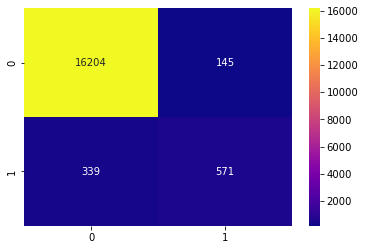

In [478]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d',cmap='plasma');

In [479]:
colors=classifier.predict(df_for_training)

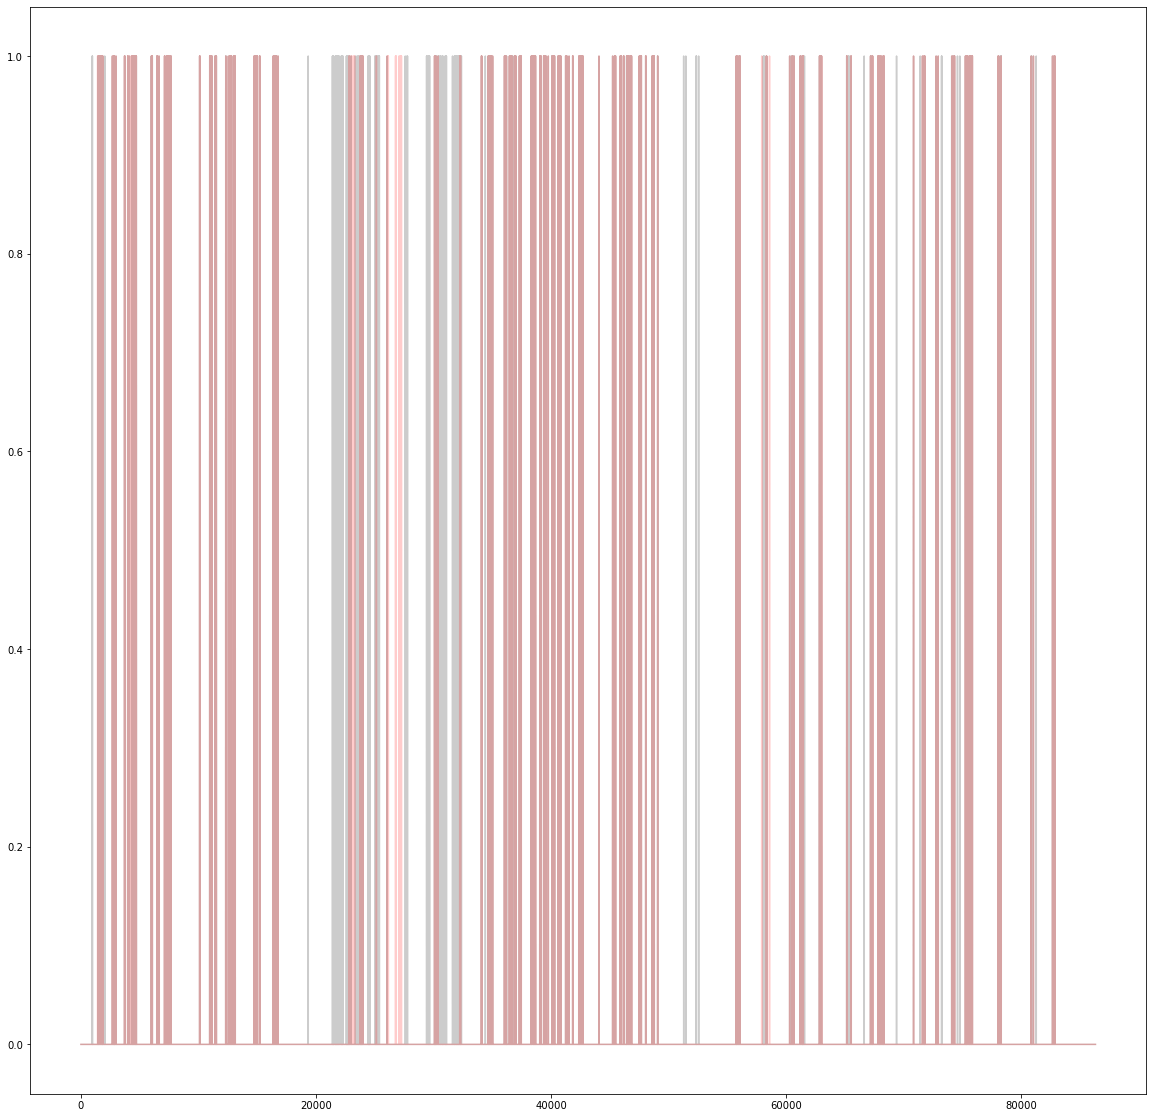

In [480]:
plt.figure(figsize=(20,20))
plt.plot(colors,'k',alpha=0.2)
plt.plot(yVar,'r',alpha=0.2)

Text(0.5, 1.0, 'predicted in dk blue')

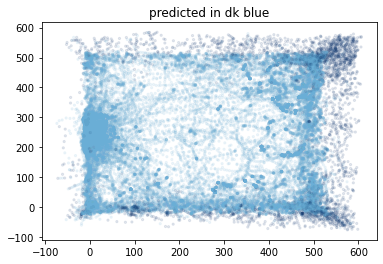

In [481]:
plt.scatter(all_aligned_dfs.nose.x,all_aligned_dfs.nose.y,c=colors,s=5,cmap="Blues",alpha=.1)
plt.clim([-1,1])
plt.title('predicted in dk blue')

Text(0.5, 1.0, 'ground truth in dark blue')

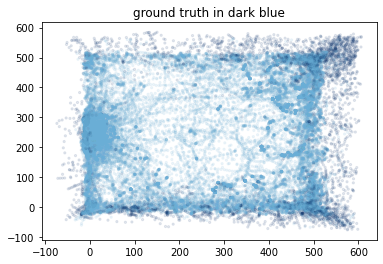

In [482]:
plt.scatter(all_aligned_dfs.nose.x,all_aligned_dfs.nose.y,c=yVar,cmap="Blues",s=5,alpha=.1)
plt.clim([-1,1])
plt.title('ground truth in dark blue')

# notes from Alex chat 20221125
- observer quant I need to annotate some
- re run on all the data we have
- send alex just-jumps
- Alex owes me videos and start times

In [173]:
# consider tortuosity of trajectory, speed profile

In [29]:
emily_anns = pd.read_csv('../data/video_anns_emily.csv')
emily_anns

,video,behavior,start_or_stop,time_in_sec,encdoed_FPS
0,5,nose_in,1.0,17.281,29.917
1,5,ears_in,1.0,18.551,NaN
2,5,ears_in,0.0,19.654,NaN
3,5,nose_in,0.0,20.122,NaN
4,5,nose_in,1.0,31.086,NaN
...,...,...,...,...,...
524,39,jump,0.0,546.314,NaN
525,39,jump,1.0,546.715,NaN
526,39,jump,0.0,547.149,NaN
527,39,jump,1.0,556.572,NaN


In [30]:
rows_to_rm=[]
emily_anns['frame']=float(0)
fps = emily_anns.encdoed_FPS[0]
for idx in emily_anns.index:
    #print(idx)
    if np.isnan(emily_anns.encdoed_FPS[idx]):
        emily_anns.encdoed_FPS[idx]=fps
    else:
        fps = emily_anns.encdoed_FPS[idx]
    emily_anns.iloc[idx,-1]=emily_anns.time_in_sec[idx]*fps
    if np.isnan(emily_anns.start_or_stop[idx]):
        rows_to_rm.append(idx)
    elif "_in" in emily_anns.behavior[idx]:
        rows_to_rm.append(idx)


C:\Users\dennise\AppData\Local\Temp\ipykernel_15212\1030031883.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emily_anns.encdoed_FPS[idx]=fps


In [31]:
emily_anns.drop(emily_anns.index[rows_to_rm], inplace=True)
emily_anns=emily_anns.reset_index().drop(columns='index')
emily_anns

,video,behavior,start_or_stop,time_in_sec,encdoed_FPS,frame
0,5,rear_supported,1.0,71.063,29.917,2125.991771
1,5,rear_supported,0.0,71.698,29.917,2144.989066
2,5,rear_supported,1.0,72.300,29.917,2162.999100
3,5,rear_supported,0.0,73.403,29.917,2195.997551
4,5,rear_supported,1.0,74.907,29.917,2240.992719
...,...,...,...,...,...,...
417,39,jump,0.0,546.314,29.926,16348.992764
418,39,jump,1.0,546.715,29.926,16360.993090
419,39,jump,0.0,547.149,29.926,16373.980974
420,39,jump,1.0,556.572,29.926,16655.973672


In [32]:
emily_anns.to_csv('../data/video_anns_emily_cleaned.csv')

In [33]:
emily_anns

,video,behavior,start_or_stop,time_in_sec,encdoed_FPS,frame
0,5,rear_supported,1.0,71.063,29.917,2125.991771
1,5,rear_supported,0.0,71.698,29.917,2144.989066
2,5,rear_supported,1.0,72.300,29.917,2162.999100
3,5,rear_supported,0.0,73.403,29.917,2195.997551
4,5,rear_supported,1.0,74.907,29.917,2240.992719
...,...,...,...,...,...,...
417,39,jump,0.0,546.314,29.926,16348.992764
418,39,jump,1.0,546.715,29.926,16360.993090
419,39,jump,0.0,547.149,29.926,16373.980974
420,39,jump,1.0,556.572,29.926,16655.973672


In [114]:
# working on transitioning to script, need to test out loading pkl file, using to predict on a df.
df = pd.read_csv('../data/39DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_aligned_dists.csv',header=[0,1])
df

Unnamed: 0_level_0        box_bl                   box_br         \
      Unnamed: 0_level_1             x      y likelihood      x      y   
0                      0  0.000000e+00  500.0   0.999807  500.0  500.0   
1                      1  0.000000e+00  500.0   0.999832  500.0  500.0   
2                      2  0.000000e+00  500.0   0.999849  500.0  500.0   
3                      3  0.000000e+00  500.0   0.999859  500.0  500.0   
4                      4  5.760037e-14  500.0   0.999788  500.0  500.0   
...                  ...           ...    ...        ...    ...    ...   
17959              17959  0.000000e+00  500.0   0.999835  500.0  500.0   
17960              17960  5.812110e-14  500.0   0.999849  500.0  500.0   
17961              17961  0.000000e+00  500.0   0.999856  500.0  500.0   
17962              17962  0.000000e+00  500.0   0.999817  500.0  500.0   
17963              17963  1.162559e-13  500.0   0.999817  500.0  500.0   

                        box_tl                           ...   tail_tip  \
      likelihood             x             y likelihood  ... likelihood   
0       0.999425  0.000000e+00  7.117104e-15   0.999978  ...   0.293948   
1       0.999105  0.000000e+00  7.117825e-15   0.999977  ...   0.310536   
2       0.998960  5.693558e-14 -7.116947e-15   0.999986  ...   0.326454   
3       0.999381  1.138557e-13  0.000000e+00   0.999985  ...   0.276298   
4       0.999701  0.000000e+00  7.115562e-15   0.999982  ...   0.239869   
...          ...           ...           ...        ...  ...        ...   
17959   0.999936  5.755170e-14  1.438793e-14   0.999932  ...   0.040843   
17960   0.999925  5.755086e-14  0.000000e+00   0.999925  ...   0.078385   
17961   0.999932  5.755119e-14  0.000000e+00   0.999916  ...   0.117359   
17962   0.999890  5.755169e-14 -7.193961e-15   0.999898  ...   0.055927   
17963   0.999934  0.000000e+00  0.000000e+00   0.999898  ...   0.058966   

               dists                                                       \
      nose_ear_right nose_ear_left nose_paw_left_back nose_paw_left_front   
0                NaN           NaN                NaN                 NaN   
1                NaN           NaN                NaN                 NaN   
2                NaN           NaN                NaN                 NaN   
3                NaN           NaN                NaN                 NaN   
4                NaN           NaN                NaN                 NaN   
...              ...           ...                ...                 ...   
17959      18.629486     17.189996                NaN                 NaN   
17960      21.536389     19.701003                NaN                 NaN   
17961      22.463593     20.914205                NaN                 NaN   
17962      22.421172     21.231541                NaN                 NaN   
17963      22.592457     21.214203                NaN                 NaN   

                                                                             \
      nose_paw_right_back nose_paw_right_front nose_tail_tip nose_tail_base   
0                     NaN                  NaN           NaN            NaN   
1                     NaN                  NaN           NaN            NaN   
2                     NaN                  NaN           NaN            NaN   
3                     NaN                  NaN           NaN            NaN   
4                     NaN                  NaN           NaN            NaN   
...                   ...                  ...           ...            ...   
17959                 NaN                  NaN           NaN            NaN   
17960           39.456385                  NaN           NaN            NaN   
17961           40.143779                  NaN           NaN            NaN   
17962           40.469550                  NaN           NaN            NaN   
17963           39.421078                  NaN           NaN            NaN   

                    speed  
      Unn

In [118]:
aligned_df=df.copy()
df_for_training=pd.concat([aligned_df['nose']['x'],aligned_df['nose','y'],aligned_df['nose']['likelihood'],aligned_df['tail_base']['likelihood'],aligned_df['tail_tip']['likelihood'],aligned_df['speed']],axis=1)
df_for_training.columns=['nose_x','nose_y','nose_likelihood','tail_base_likelihood','tail_tip_likelihood','speed']

In [120]:
for col in ['nose_x','nose_y','speed']:
    maxval=np.nanmax(df_for_training[col])
    df_for_training[col]=df_for_training[col]/np.nanmax(df_for_training[col])

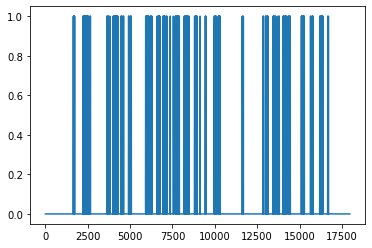

In [124]:
plt.plot(clf.predict(df_for_training.fillna(0)))

In [136]:
'../data/'

NameError: name '__file__' is not defined

In [9]:
column_vals=['sub_file_name','total_frames','num_entrances','first_frame_in_center','frames_with_nose','frames_with_head','frames_with_body','frames_within_50mm','fraction_frames_within_50mm','fraction_LIGHT_frames_within_50mm','fraction_LIGHT_frames_in_center','num_jumps']

In [22]:
full_path_list=['tst','2']
total_frames=[0,1]
num_entrances=[1,2]
first_frame_in_center=[2,2]
frames_with_nose=[3,3]
frames_with_head=[4,4]
frames_with_body=[5,10]
frames_within_50mm=[6,12]
fraction_frames_within_50mm=[.7,.7]
fraction_LIGHT_frames_within_50mm=[.8,.8]
fraction_LIGHT_frames_in_center=[.9,.9]
num_jumps=[10,10]

In [27]:
zipped=zip(full_path_list,total_frames,num_entrances,first_frame_in_center,frames_with_nose,frames_with_head,frames_with_body,frames_within_50mm, fraction_frames_within_50mm,fraction_LIGHT_frames_within_50mm,fraction_LIGHT_frames_in_center,num_jumps)
zipped

In [28]:
pd.DataFrame(zipped,columns=column_vals)

,sub_file_name,total_frames,num_entrances,first_frame_in_center,frames_with_nose,frames_with_head,frames_with_body,frames_within_50mm,fraction_frames_within_50mm,fraction_LIGHT_frames_within_50mm,fraction_LIGHT_frames_in_center,num_jumps
0,tst,0,1,2,3,4,5,6,0.7,0.8,0.9,10
1,2,1,2,2,3,4,10,12,0.7,0.8,0.9,10


In [30]:
import numpy as np

In [34]:
zipped=zip(['C:\\Users\\dennise\\Desktop\\AlexF\\VID_20210925_134723DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv'],[17957],[30.0],[446],[9442],[9086],[8702],[],[0.44244584284680066],[np.array([0.84145308])],[np.array([0.15854692])],[188.0])

In [35]:
pd.DataFrame(zipped,columns=column_vals)

,sub_file_name,total_frames,num_entrances,first_frame_in_center,frames_with_nose,frames_with_head,frames_with_body,frames_within_50mm,fraction_frames_within_50mm,fraction_LIGHT_frames_within_50mm,fraction_LIGHT_frames_in_center,num_jumps
0,C:\Users\dennise\Desktop\AlexF\VID_20210925_13...,17957,30.0,446,9442,9086,8702,1,0.442446,[0.84145308],[0.15854692],188.0


In [41]:
jump_bouts=[0,0,0,0,0,1,1,0,0,0,20,20,20,20,20,20,20,20,0,0,0,0,0,23,23,0,0,0,0,0,0,0,0]



2